# NT1 - Data Oganizer for geotechnical data analysis and plotting

## Query Data Organizer for E, sigma_c, tau, then write to lists and show report tables 

In [1]:
# Notes for data preparation!
# -data preparation in lab spreadsheet (best in git hub)
# -csv export a) check number formats, etc; b) check missing data fields (make sure they are blank and not string!)
# -csv import into couchbase (reference csv inoporting notebook)



In [2]:
# Explanation of testing and of data analysis
# - aim is to provide short, concise text that can be used for a geotechnical factual report



In [3]:
# open Data Organizer
from DataOrganizer import CouchbaseSelector
db = CouchbaseSelector('localhost','geotechnical')

In [4]:
# set up python ecosystem
import json
from math import *
import pandas as pd
import numpy as np
from IPython.core.display import HTML, display
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import stats

In [5]:
# Notes:
# - To rerun analysis, best to choose Cell --> Run All
#   Rerunning an individual cell can give unexpected results. Unclear why.                                #ToDo JK

In [6]:
# add documentation for using functions 
# define data map-reduce functions that are frequently reused here

# define selection of values by project_phase
def select_data(data,data_sel,project_phase):
    for item in data:
        if (item['value']) != 'NaN':
            if (item['sample_description']) == project_phase:
                data_sel.append(float(item['value']))
    print('count for selected E: '+str(len(data_sel)))    # record count for checking

# define selection of data by lithology
def select_by_lithology(data, lithology, dict, sample_description): #data is data set from Data Organiser
    dict[lithology]=[]                                              #dict is a new data set ordered by lithology
    for item in data:
        if (item['value']) != 'NaN':
            if (item['sample_description']) == sample_description:
                if (item['lithology']) == lithology:
                    dict[lithology].append(float(item['value']))

# select strength data from test results and write to dictionary
def selected_strengths(sample_description, sig1, sig3):
    for key,value in tests.items():  #loop over test types (=key)
        for lithology in lithologies:
            sig1[key][lithology]=[]  #initialize dictionary
            sig3[key][lithology]=[]  #initialize dictionary
        for rec in value:  #for each record of input data
            if (rec['test_type']) == test_names[key]: #select for test type 
                if (rec['value']) != 'NaN':  #ignore NaN values
                    if (rec['sample_description']) == sample_description:  #select for phase
                        for lithology in lithologies:  # select for lithology
                            if (rec['lithology']) == lithology:
                                sig1[key][lithology].append(float(rec['value']))
                                try: 
                                    float(rec['test_parameters']) 
                                    sig3[key][lithology].append(float(rec['test_parameters']))
                                except:
                                    sig3[key][lithology].append(float(0))  #set 'test_parameter' = 0 if missing

# select E, sgima_c data pairs and write to dictionary
#def selected_pairs(sample_description):

#def count_selected_strengths(sig1,description):  #counts for data checking


In [7]:
# define plotting variables and functions that are frequently reused here

# define dict for lithology colors (https://en.wikipedia.org/wiki/X11_color_names)
colors={'Red Sandstone':'red', 'Sandstone':'orange', 'Siltstone':'green', 'Conglomerate':'brown', 
        'Mudstone':'yellow' , 'Sheared Mudstone':'magenta', 'Clay':'black', 'Silty Sandstone':'khaki'}

# define markers fortest types
markers={'ucs':'o', 'tx':'^', 'ds':'>'} 

# define rand_jitter to move plotted points slightly in order to reduce overlapping data points
def rand_jitter(arr):
    if not arr.any():
        pass
    else:
        stdev = .01*(max(arr)-min(arr))
        return arr + np.random.randn(len(arr)) * stdev

# define legend for lithologies and test types 
def legend_for_litholgies_tests(legend_loc):    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="magenta")
    sym8 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="khaki")
    sym10 = Line2D([0], [0], linestyle="none", marker="o", alpha=1.0, markersize=10, color="black")
    sym11 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym12 = Line2D([0], [0], linestyle="none", marker=">", alpha=1.0, markersize=10, color="black")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym8,sym10,sym11,sym12),
           ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone",
            "Silty Sandstone","UCS","TX","DS"),fontsize=11, numpoints=1,loc=legend_loc)
    
# defne a basic histogram plot routine 
def plot_e50(E,project_phase):
    # plot histogram of all E50 values
    # input: E containing 'values' of 'parameter' E

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # plot histogram of E values for all rock lithologies
    hist,bin_edges,patches = ax2.hist(E, 20, normed=0, facecolor='green', alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)

    # plot distribution of E values using scipy
    # param[0] and param[1] are the mean and the standard deviation of the fitted distribution
    param = norm.fit(E) 
    y = mlab.normpdf( bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'r--', linewidth=1)  #plot pdf
    ax1.set_ylabel('Probability',fontsize=11)

    # plot axis labels and grid
    ax1.set_xlabel(project_phase+': ALL LITHOLIGIES E-Modulus E50 (MPa)',fontsize=11)
    plt.rc('xtick', labelsize=9)
    plt.rc('ytick', labelsize=9)  
    ax1.grid(True)

    plt.show()

    #reprot mean and standar deviation
    print('mean = '+str(format(param[0],'.0f')))
    print('standard deviation = '+str(format(param[1],'.0f')))




In [8]:
# query Data Organizer records for 'parameter' = E 
# sorting by borehole_code and sample_depth

# initialize variables
data_E=[]

parameter = 'E'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_type']
selector = {'project_code': 'NT1.r2', 'data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write rec to data_E if measurement_convention is E50 or is blank (assued to be E50)
# if value for E is blank, replace with 'NaN'    
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    if rec['measurement_convention'] != 'Es':
      data_E.append(rec)

# map field 'measurement_convention' to 'project_phase' for better code readability                                                              #ToDo JK    
print('count for E: '+str(len(data_E)))  # record count for checking

count for E: 68


In [9]:
# write returned Data Organizer list to a pandas data frame and display as html
data_E_df = pd.DataFrame(data=data_E)
data_E_df.columns = [u'Borehole', u'Lithology', u'Measurement', u'Depth', u'Sample', u'Test', u'Value', u'Unit']
display(HTML('<h4>Laboratory Testing Data - E measured during compressive testing</h3>'))
display(HTML(data_E_df.to_html()))                                                             
##display(HTML(data_E_df.to_html(formatters={'value':lambda x: u'{:06.2f}'.format(float(x))})))
# order columns of report tables to something more suitable                                             #ToDo JK
# name column 'Sample' to 'Project phase'                                                               #ToDo JK

,Borehole,Lithology,Measurement,Depth,Sample,Test,Value,Unit
0,NT1-1,Conglomerate,E50,27.10,Basic Design,E measured during uniaxial compression,3352.00,MPa
1,NT1-1,Conglomerate,E50,61.50,Basic Design,E measured during uniaxial compression,3532.00,MPa
2,NT1-11,Sandstone,E50,15.65,Basic Design,E measured during uniaxial compression,3142.00,MPa
3,NT1-14,Red Sandstone,E50,28.90,Construction Design,E measured during uniaxial compression,13200.00,MPa
4,NT1-14,Red Sandstone,E50,36.80,Construction Design,E measured during uniaxial compression,51400.00,MPa
5,NT1-14,Red Sandstone,E50,37.30,Construction Design,E measured during uniaxial compression,19700.00,MPa
6,NT1-14,Red Sandstone,E50,37.30,Construction Design,E measured during uniaxial compression,17800.00,MPa
7,NT1-14,Red Sandstone,E50,56.80,Construction Design,E measured during uniaxial compression,22100.00,MPa
8,NT1-15,Mudstone,E50,31.90,Construction Design,E measured during triaxial compression,8770.00,MPa
9,NT1-15,Mudstone,E50,31.90,Construction Design,E measured during triaxial compression,6830.00,MPa


In [10]:
# query Data Organizer records for 'parameter' = E from field testing
# sorting by borehole_code and sample_depth

# initialize variables
data_E_field=[]

parameter = 'E'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_type']
selector = {'project_code': 'NT1.r2', 'data_source': 'Field'}
##sort = ['borehole_code','sample_depth_top_m']

# write rec to data_E if measurement_convention is E50 or is blank (assued to be E50)
# if value for E is blank, replace with 'NaN'    
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    if rec['measurement_convention'] != 'Es':
      data_E_field.append(rec)

# map field 'measurement_convention' to 'project_phase' for better code readability                                                              #ToDo JK    
print('count for E: '+str(len(data_E_field)))  # record count for checking

count for E: 60


In [11]:
# write returned Data Organizer list to a pandas data frame and display as html
data_E_field_df = pd.DataFrame(data=data_E_field)
data_E_field_df.columns = [u'Borehole', u'Lithology', u'Measurement', u'Depth', u'Sample', u'Test', u'Value', u'Unit']
display(HTML('<h4>Field Testing Data - E measured</h3>'))
display(HTML(data_E_field_df.to_html()))                                                             
##display(HTML(data_E_df.to_html(formatters={'value':lambda x: u'{:06.2f}'.format(float(x))})))
# order columns of report tables to something more suitable                                             #ToDo JK
# name column 'Sample' to 'Project phase'                                                               #ToDo JK

,Borehole,Lithology,Measurement,Depth,Sample,Test,Value,Unit
0,NT1-5,Sandstone,,14.50,Basic Design,Dilatometer,1820.00,MPa
1,NT1-5,Sandstone,,24.00,Basic Design,Dilatometer,3390.00,MPa
2,NT1-5,Sandstone,,31.50,Basic Design,Dilatometer,4910.00,MPa
3,NT1-5,Sandstone,,36.00,Basic Design,Dilatometer,2330.00,MPa
4,NT1-5,Sandstone,,43.50,Basic Design,Dilatometer,5100.00,MPa
5,NT1-5,Sandstone,,45.00,Basic Design,Dilatometer,4070.00,MPa
6,NT1-5,Conglomerate,,46.30,Basic Design,Dilatometer,3200.00,MPa
7,NT1-5,Sandstone,,50.00,Basic Design,Dilatometer,4180.00,MPa
8,NT1-5,Sandstone,,54.30,Basic Design,Dilatometer,880.00,MPa
9,NT1-5,Sandstone,,59.00,Basic Design,Dilatometer,2020.00,MPa


In [12]:
# query Data Organizer records for 'parameter' = sigma_c
# sorting by borehole_code and sample_depth

# initialize variables
data_sigma_c=[]

parameter = 'sigma_c'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1.r2','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3     #ToDo JK
    #print rec['test_parameters'][0]['value']

    data_sigma_c.append(rec)
    
print('count for sigma_c: '+str(len(data_sigma_c)))  # record count for checking

count for sigma_c: 78


In [13]:
# write returned Data Organizer list to a pandas data frame and display as html
data_sigma_c_df = pd.DataFrame(data=data_sigma_c)
data_sigma_c_df.columns = [u'Borehole',u'Lithology',u'Depth',u'Sample',u's3',u'Test',u'Value',u'Unit']
display(HTML('<h4>Laboratory Testing Data - sigma_c from compressive testing</h4>'))
display(HTML(data_sigma_c_df.to_html()))

,Borehole,Lithology,Depth,Sample,s3,Test,Value,Unit
0,NT1-1,Conglomerate,27.10,Basic Design,,Uniaxial compression,86.82,MPa
1,NT1-1,Conglomerate,61.50,Basic Design,,Uniaxial compression,75.15,MPa
2,NT1-11,Sandstone,15.65,Basic Design,,Uniaxial compression,85.02,MPa
3,NT1-14,Red Sandstone,28.90,Construction Design,5.00,Triaxial compression,128.55,MPa
4,NT1-14,Red Sandstone,28.90,Construction Design,,Uniaxial compression,56.01,MPa
5,NT1-14,Red Sandstone,28.90,Construction Design,1.00,Triaxial compression,90.54,MPa
6,NT1-14,Red Sandstone,28.90,Construction Design,3.00,Triaxial compression,127.17,MPa
7,NT1-14,Red Sandstone,36.80,Construction Design,,Uniaxial compression,106.68,MPa
8,NT1-14,Red Sandstone,37.30,Construction Design,,Uniaxial compression,126.68,MPa
9,NT1-14,Red Sandstone,37.30,Construction Design,,Uniaxial compression,78.68,MPa


In [14]:
# query Data Organizer records for 'parameter' = tau
# sorting by borehole_code and sample_depth

# initialize variables
data_tau=[]

parameter = 'tau'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1.r2','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3     #ToDo JK

    ##if rec['measurement_convention'] == 'Peak strength':  #tmp - should handled in plot data             #ToDo JK
    ##  data_tau.append(rec)
    data_tau.append(rec)
    
print('count for tau: '+str(len(data_tau)))  # record count for checking

count for tau: 75


In [15]:
# write returned Data Organizer list to a pandas data frame and display as html
data_tau_df = pd.DataFrame(data=data_tau)
data_tau_df.columns = [u'Borehole', u'Lithology', u'Measurement', u'Depth', u'Sample', u's3', u'Test', 
                       u'Value', u'Unit']
display(HTML('<h4> Laboratory Testing Data - tau measured during direct shear testing</h4>'))
display(HTML(data_tau_df.to_html()))

,Borehole,Lithology,Measurement,Depth,Sample,s3,Test,Value,Unit
0,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.80,Direct shear,0.46,MPa
1,Diversion Tunnel,Sheared Mudstone,Peak strength,,Construction Design,0.20,Direct shear,0.14,MPa
2,Diversion Tunnel,Sheared Mudstone,Peak strength,,Construction Design,0.40,Direct shear,0.18,MPa
3,Diversion Tunnel,Sheared Mudstone,Peak strength,,Construction Design,0.80,Direct shear,0.37,MPa
4,Diversion Tunnel,Sheared Mudstone,Peak strength,,Construction Design,0.80,Direct shear,0.41,MPa
5,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.40,Direct shear,0.23,MPa
6,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.20,Direct shear,1.68,MPa
7,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.40,Direct shear,0.25,MPa
8,Diversion Tunnel,Sheared Mudstone,Peak strength,,Construction Design,0.20,Direct shear,0.07,MPa
9,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.80,Direct shear,0.46,MPa


## Plot histograms for E50 data

In [16]:
# prepare E values for histogram 
# input: data_E
data_E_sel=[]
select_data(data_E,data_E_sel,'Basic Design')

count for selected E: 21


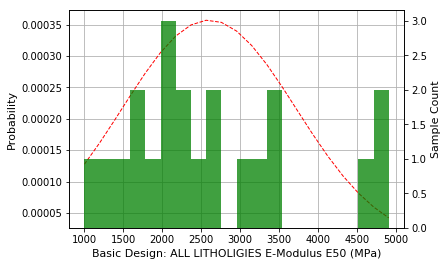

mean = 2603
standard deviation = 1117


In [17]:
# plot histogram of all E50 values
# input: data_E_sel containing 'values' of 'parameter' E
plot_e50(data_E_sel,'Basic Design')

In [18]:
# prepare E values for histogram 
# input: data_E
data_E_sel=[]
select_data(data_E,data_E_sel,'Construction Design')

count for selected E: 47


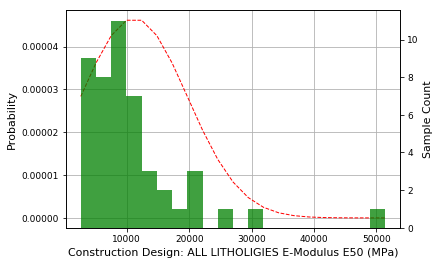

mean = 11163
standard deviation = 8562


In [19]:
# plot histogram of all E50 values
# input: data_E_sel containing 'values' of 'parameter' E
plot_e50(data_E_sel,'Construction Design')

In [20]:
# prepare E values for selected lithologies 
# input: data_E

dict_E_basic={}
dict_E_const={}

# rework as loops over project_phases and lithologies                                                   #ToDo JK
select_by_lithology(data_E, 'Red Sandstone', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Sandstone', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Siltstone', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Mudstone', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Conglomerate', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Clay', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Sheared Mudstone', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Silty Sandstone', dict_E_const, 'Construction Design')

select_by_lithology(data_E, 'Red Sandstone', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Sandstone', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Siltstone', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Mudstone', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Conglomerate', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Clay', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Sheared Mudstone', dict_E_basic, 'Basic Design')

#print(dict_E_const)
#print(dict_E_basic)

In [21]:
print(dict_E_const)

{'Sheared Mudstone': [], 'Silty Sandstone': [2630.0, 8180.0], 'Sandstone': [31500.0, 14200.0, 14900.0, 7120.0, 11800.0, 8590.0, 2680.0, 4410.0, 8850.0, 6080.0], 'Red Sandstone': [13200.0, 51400.0, 19700.0, 17800.0, 22100.0], 'Siltstone': [4170.0, 7940.0, 11800.0, 9579.0, 6867.0, 2790.0, 6760.0, 3710.0, 4130.0, 8674.0, 11660.0, 11510.0, 20700.0, 11400.0, 4290.0, 7780.0, 7450.0, 12000.0, 16800.0, 8680.0, 2980.0, 9300.0, 13200.0, 9140.0, 11900.0, 5650.0, 27000.0, 6050.0], 'Conglomerate': [], 'Mudstone': [8770.0, 6830.0], 'Clay': []}


,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Red Sandstone,5,24840,19700,1.32,13597
1,Siltstone,28,9425,8677,1.46,5298
2,Sandstone,10,11013,8720,1.60,7802
3,Mudstone,2,7800,7800,0.00,970
4,Silty Sandstone,2,5405,5405,0.00,2775


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Red Sandstone,24840,13597,2473
1,Siltstone,9425,5298,710
2,Sandstone,11013,7802,-1821
3,Mudstone,7800,970,6204
4,Silty Sandstone,5405,2775,840


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Red Sandstone,5,11877,36065
1,Siltstone,28,7720,6975
2,Sandstone,10,6490,13530
3,Mudstone,2,3469,21876
4,Silty Sandstone,2,-6984,62584


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Red Sandstone,24505,22088,17947,11771,10439
1,Siltstone,9455,8151,6056,5560,3326
2,Sandstone,11009,8883,5784,8058,3024
3,Mudstone,7800,7739,7619,979,6301
4,Silty Sandstone,5448,4638,3362,3357,1824


,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Sandstone,5,3696,3232,0.26,896
1,Siltstone,13,1877,2000,-0.21,456
2,Conglomerate,3,3926,3532,0.67,689


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Sandstone,3696,896,2221
1,Siltstone,1877,456,1127
2,Conglomerate,3926,689,2793


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Sandstone,5,2841,2378
1,Siltstone,13,1652,719
2,Conglomerate,3,2765,3725


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Sandstone,3695,3589,3385,908,2410
1,Siltstone,1881,1816,1693,507,1174
2,Conglomerate,3925,3870,3763,662,2938


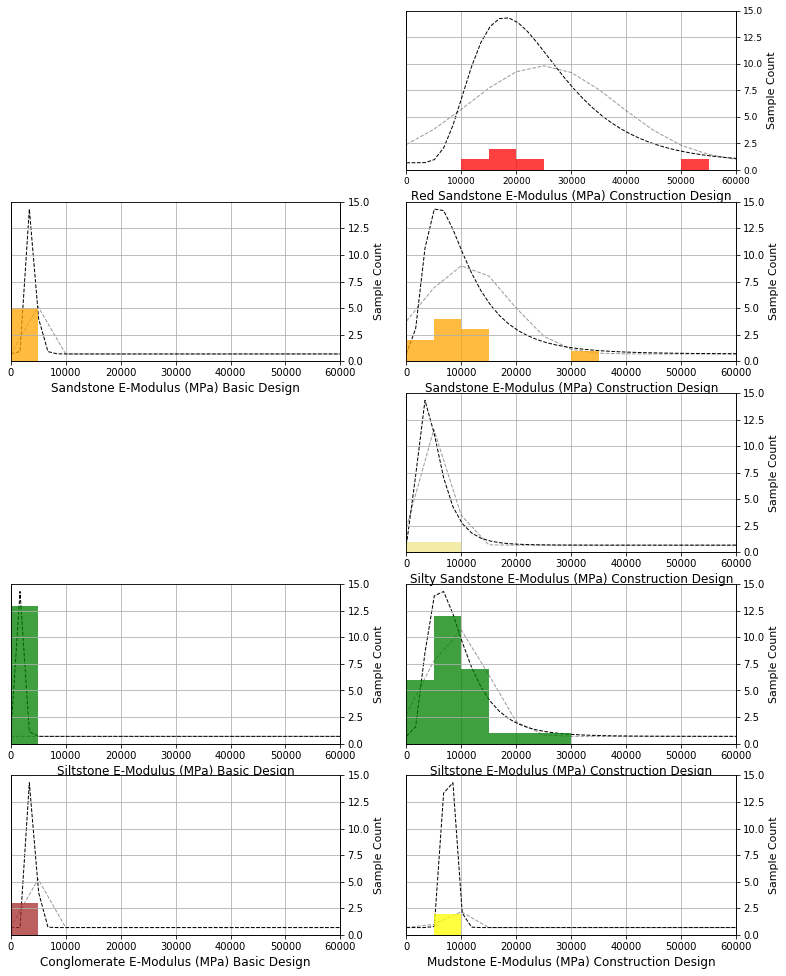

In [22]:
# plot histogram of all E values for selected lithologies 
# input: dict_E_const and dict_E_basic containing 'values' of 'parameter' E 
# adjust: bins,ylim,xlim,xfit,ax1.set_xlabel,display(HTML)

sample_statistics=[]
fitted_norm_dist_parameters=[]
fitted_lognorm_dist_parameters=[]
confidence_limits_norm_dist=[]

def histogram_by_lithology(dict, lithology, sample_description):
    # plot histogram of values for all rock lithologies
    ax2 = ax1.twinx()
    hist,bin_edges,patches = ax2.hist(dict[lithology],bins=[0,5000,10000,15000,20000,25000,30000,35000,40000,
                                                            45000,50000,55000,60000],
                                      normed=0,facecolor=colors[lithology],alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)
    ax2.set_ylim(0,15)
    ax2.set_xlim(0,60000)

    # plot normal distribution of values using scipy
    param = norm.fit(dict[lithology])  #param[0] and param[1] are mean and standard deviation
    #mean,var = norm.stats(param[0], param[1], moments='mv')  #check
    #ci_90 = norm.interval(0.90, param[0], param[1])  #endpoints of range containing 90 percent of distribution
    y = mlab.normpdf(bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'k--', linewidth=1, alpha=0.4)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # plot lognormal distribution of E values using scipy  #use of lognorm.fit to be checked!             #ToDo JK
    shape, loc, scale = lognorm.fit(dict[lithology],floc=0)  #mu=log(scale), sigma=shape
    # floc=0 -> equivalent to fitting log(data) using stats.norm.fit, e.g. takes care of log transformation
    fitted_lognorm_mean=exp(np.log(scale)+shape**2/2)  #reference: wikipedia.org/wiki/Log-normal_distribution 
    fitted_lognorm_median=scale  #reference as above
    fitted_lognorm_mode=exp(np.log(scale)-shape**2)  #reference as above
    fitted_lognorm_var=(exp(shape**2)-1)*exp(2*np.log(scale)+shape**2)  #reference as above
    lognorm_ci_90 = lognorm.interval(0.90, shape, loc, scale)  #endpoints of range containing 90% of distribution
    fitted_lognorm_fract_5 = lognorm_ci_90[0]  #5% fractile (= lower endpoint of 90% confidence interval)
    x_fit = np.linspace(0,100000,60)
    y = lognorm.pdf(x_fit, shape, loc, scale)
    ll = ax1.plot(x_fit, y, 'k--', linewidth=1)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # sample statistics
    sample_count=len(dict[lithology])  #n
    sample_mean=np.mean(dict[lithology])
    sample_median=np.median(dict[lithology])
    sample_skew=stats.skew(dict[lithology])
    sample_std_dev=np.std(dict[lithology])
    sample_statistics.append((lithology,
                          str(sample_count),
                          str(format(sample_mean,'.0f')),
                          str(format(sample_median,'.0f')),
                          str(format(sample_skew,'.2f')),
                          #str(format(sample_mode,'.0f')),
                          str(format(sample_std_dev,'.0f'))))
    
    # fitted normal distribution parameters
    fitted_norm_mean = param[0]  #mean of fitted distribution
    fitted_norm_std_dev = param[1]  #standard deviation of fitted distribution
    fitted_norm_conf_limit = fitted_norm_mean - fitted_norm_std_dev*1.645  #5% fractile (of 90% confidence interval)
    fitted_norm_dist_parameters.append((lithology,
                       str(format(fitted_norm_mean,'.0f')),  
                       str(format(fitted_norm_std_dev,'.0f')),
                       str(format(fitted_norm_conf_limit,'.0f'))))

    # confidence interval to normal distribution considering sampling
    confidence_limit_t = stats.t.ppf(1-0.05, sample_count-1)  #t-dist one-sided lower 95% confidence limit
    confidence_limit_chi2 = stats.chi2.ppf(0.05,sample_count-1)  #one-sided chi-square upper 95% confidence limit
    confidence_limit_mean = fitted_norm_mean-fitted_norm_std_dev*confidence_limit_t/sqrt(sample_count)
    confidence_limit_std_dev = sqrt(sample_count/confidence_limit_chi2)*fitted_norm_std_dev
    confidence_limits_norm_dist.append((lithology,
                       str(sample_count),  #sample count
                       str(format(confidence_limit_mean,'.0f')),  #95% lower confidence limit of mean
                       str(format(confidence_limit_std_dev,'.0f'))))  #95% upper confidence limit of std_dev

    # fitted lognormal distribution parameters
    fitted_lognorm_dist_parameters.append((lithology,
                        str(format(fitted_lognorm_mean,'.0f')),
                        str(format(fitted_lognorm_median,'.0f')),
                        str(format(fitted_lognorm_mode,'.0f')),                       
                        str(format(sqrt(fitted_lognorm_var),'.0f')),  #standard deviation
                        str(format(fitted_lognorm_fract_5,'.0f'))))  #95% confidence interval

    #print('mean: '+str(format(np.mean(dict[lithology]),'.0f'))+
    #      '   median: '+str(format(np.median(dict[lithology]),'.0f'))+
    #      '   mode: '+str(format(float(mode(dict[lithology])[0]),'.0f'))+
    #      '   std_dev: '+str(format(np.std(dict[lithology]),'.0f')))
    #print('count: '+str(sample_count)+'   CL_mean: '+str(format(confidence_limit_mean,'.0f'))+
    #      '   CL_std_dev: '+str(format(confidence_limit_std_dev,'.0f')))

    # plot axis labels and grid
    ax1.set_xlabel(lithology+' E-Modulus (MPa) '+sample_description,fontsize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)  
    ax1.axes.get_yaxis().set_ticks([])  #supress pdf lables on left y-axis
    ax1.grid(True); ax2.grid(True)

# report sample statistics
def report_sample_statistics(project_phase):  #
    sample_statistics_df = pd.DataFrame(data=sample_statistics)
    sample_statistics_df.columns = [u'Lithology', u'count', u'mean (MPa)', u'median (MPa)', u'skew',
                                    u'standard deviation (MPa)']
    display(HTML('<h4>Sample statistics of E values - '
                 +project_phase+'</h3>'))
    display(HTML(sample_statistics_df.to_html()))

# report fitted normal distribution parameters
def report_fitted_norm_dist_parameters(project_phase):  #fitted_norm_dist_parameters
    fitted_norm_dist_parameters_df = pd.DataFrame(data=fitted_norm_dist_parameters)
    fitted_norm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'standard deviation (MPa)', 
                                              u'95% CI (MPa)']
    display(HTML('<h4>Parameters of normal distribution fitted to sampled E values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_norm_dist_parameters_df.to_html(
                 formatters={'mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

# report confidence intervals considering sampling
def report_confidence_limits_norm_dist(project_phase):  #
    confidence_limits_norm_dist_df = pd.DataFrame(data=confidence_limits_norm_dist)
    confidence_limits_norm_dist_df.columns = [u'Lithology', u'count', 
                                    u'95% CI of mean (MPa)', u'95% CI of std_dev (MPa)']
    display(HTML('<h4>Confidence intervals of testing against normal distribution of E values - '
                 +project_phase+'</h3>'))
    display(HTML(confidence_limits_norm_dist_df.to_html(
                 formatters={'count':lambda x: '<strong>%s</strong>' %x,
                             '95% CI of mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

def report_fitted_lognorm_dist_parameters(project_phase):
    fitted_lognorm_dist_parameters_df = pd.DataFrame(data=fitted_lognorm_dist_parameters)
    fitted_lognorm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'median (MPa)', u'mode (MPa)', 
                                                 u'standard deviation (MPa)', u'95% CI (MPa)']
    display(HTML('<h4>Parameters of lognormal distribution fitted to sampled E values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_lognorm_dist_parameters_df.to_html()))


fig = plt.figure(figsize=(13,17))
ax1 = fig.add_subplot(5, 2, 2)  #4 rows, 3 columns, 2nd position
histogram_by_lithology(dict_E_const, 'Red Sandstone', 'Construction Design')
ax1 = fig.add_subplot(5, 2, 8)
histogram_by_lithology(dict_E_const, 'Siltstone', 'Construction Design')
ax1 = fig.add_subplot(5, 2, 4)
histogram_by_lithology(dict_E_const, 'Sandstone', 'Construction Design')
ax1 = fig.add_subplot(5, 2, 10)
histogram_by_lithology(dict_E_const, 'Mudstone', 'Construction Design')
ax1 = fig.add_subplot(5, 2, 6)
histogram_by_lithology(dict_E_const, 'Silty Sandstone', 'Construction Design')
report_sample_statistics('Construction Design')
report_fitted_norm_dist_parameters('Construction Design')
report_confidence_limits_norm_dist('Construction Design')
report_fitted_lognorm_dist_parameters('Construction Design')

sample_statistics=[]
fitted_norm_dist_parameters=[]
confidence_limits_norm_dist=[]
fitted_lognorm_dist_parameters=[]
ax1 = fig.add_subplot(5, 2, 3)
histogram_by_lithology(dict_E_basic, 'Sandstone', 'Basic Design')
ax1 = fig.add_subplot(5, 2, 7)
histogram_by_lithology(dict_E_basic, 'Siltstone', 'Basic Design')
ax1 = fig.add_subplot(5, 2, 9)
histogram_by_lithology(dict_E_basic, 'Conglomerate', 'Basic Design')
report_sample_statistics('Basic Design')
report_fitted_norm_dist_parameters('Basic Design')
report_confidence_limits_norm_dist('Basic Design')
report_fitted_lognorm_dist_parameters('Basic Design')
plt.show()
##fig.canvas.draw()

In [23]:
print stats.t.ppf(1-0.05, 13-1)  #one-sided lower 95% confidence interval

1.782287555649159


In [24]:
print stats.chi2.ppf(0.05,26)  #95% one-sided upper confidence limit

15.37915658326173


In [25]:
# prepare E values for selected lithologies 
# input: data_E

dict_E_field_basic={}

# rework as loops over project_phases and lithologies                                                   #ToDo JK

select_by_lithology(data_E_field, 'Red Sandstone', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Sandstone', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Siltstone', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Mudstone', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Conglomerate', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Clay', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Sheared Mudstone', dict_E_field_basic, 'Basic Design')

#print(dict_E_field_basic)

In [26]:
print(dict_E_field_basic)

{'Sheared Mudstone': [], 'Sandstone': [1820.0, 3390.0, 4910.0, 2330.0, 5100.0, 4070.0, 4180.0, 880.0, 2020.0, 3840.0, 3200.0, 2150.0, 4620.0, 3250.0, 4780.0, 2950.0, 3970.0, 6040.0, 4230.0, 7490.0, 6740.0, 773.0, 7590.0, 5030.0, 7760.0, 6790.0, 6450.0, 7240.0, 6460.0, 5410.0, 4470.0, 5780.0, 1150.0, 1850.0, 1320.0, 2130.0, 1590.0], 'Red Sandstone': [], 'Siltstone': [2880.0, 3450.0, 2580.0, 3560.0, 3430.0, 3770.0, 2700.0, 3450.0, 3160.0, 4060.0, 3620.0, 4020.0, 2880.0, 3830.0, 3760.0, 3760.0, 4140.0, 3900.0, 2850.0, 3270.0], 'Conglomerate': [3200.0, 3370.0, 1800.0], 'Mudstone': [], 'Clay': []}


,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Sandstone,37,4155,4180,0.08,2059
1,Siltstone,20,3454,3505,-0.38,464
2,Conglomerate,3,2790,3200,-0.68,703


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Sandstone,4155,2059,769
1,Siltstone,3454,464,2691
2,Conglomerate,2790,703,1633


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Sandstone,37,3584,2596
1,Siltstone,20,3274,652
2,Conglomerate,3,1604,3804


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Sandstone,4286,3535,2404,2939,1273
1,Siltstone,3454,3421,3355,485,2718
2,Conglomerate,2798,2688,2479,812,1684


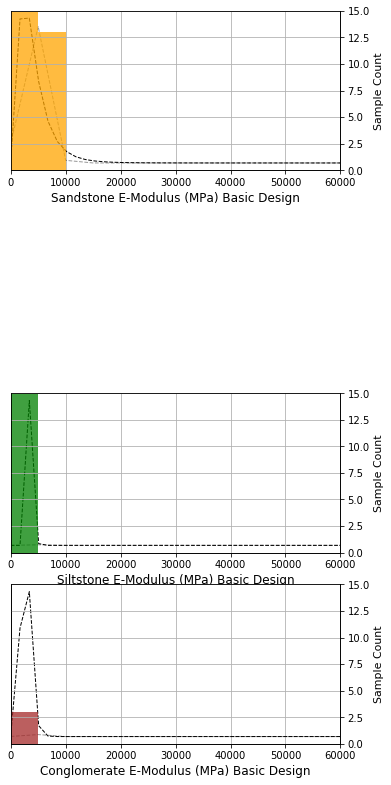

In [27]:
# plot histogram of all E values for selected lithologies 
# input: dict_E_const and dict_E_basic containing 'values' of 'parameter' E 
# adjust: bins,ylim,xlim,xfit,ax1.set_xlabel,display(HTML)

sample_statistics=[]
fitted_norm_dist_parameters=[]
fitted_lognorm_dist_parameters=[]
confidence_limits_norm_dist=[]

def histogram_by_lithology(dict, lithology, sample_description):
    # plot histogram of values for all rock lithologies
    ax2 = ax1.twinx()
    hist,bin_edges,patches = ax2.hist(dict[lithology],bins=[0,5000,10000,15000,20000,25000,30000,35000,40000,
                                                            45000,50000,55000,60000],
                                      normed=0,facecolor=colors[lithology],alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)
    ax2.set_ylim(0,15)
    ax2.set_xlim(0,60000)

    # plot normal distribution of values using scipy
    param = norm.fit(dict[lithology])  #param[0] and param[1] are mean and standard deviation
    #mean,var = norm.stats(param[0], param[1], moments='mv')  #check
    #ci_90 = norm.interval(0.90, param[0], param[1])  #endpoints of range containing 90 percent of distribution
    y = mlab.normpdf(bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'k--', linewidth=1, alpha=0.4)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # plot lognormal distribution of E values using scipy  #use of lognorm.fit to be checked!             #ToDo JK
    shape, loc, scale = lognorm.fit(dict[lithology],floc=0)  #mu=log(scale), sigma=shape
    # floc=0 -> equivalent to fitting log(data) using stats.norm.fit, e.g. takes care of log transformation
    fitted_lognorm_mean=exp(np.log(scale)+shape**2/2)  #reference: wikipedia.org/wiki/Log-normal_distribution 
    fitted_lognorm_median=scale  #reference as above
    fitted_lognorm_mode=exp(np.log(scale)-shape**2)  #reference as above
    fitted_lognorm_var=(exp(shape**2)-1)*exp(2*np.log(scale)+shape**2)  #reference as above
    lognorm_ci_90 = lognorm.interval(0.90, shape, loc, scale)  #endpoints of range containing 90% of distribution
    fitted_lognorm_fract_5 = lognorm_ci_90[0]  #5% fractile (= lower endpoint of 90% confidence interval)
    x_fit = np.linspace(0,100000,60)
    y = lognorm.pdf(x_fit, shape, loc, scale)
    ll = ax1.plot(x_fit, y, 'k--', linewidth=1)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # sample statistics
    sample_count=len(dict[lithology])  #n
    sample_mean=np.mean(dict[lithology])
    sample_median=np.median(dict[lithology])
    sample_skew=stats.skew(dict[lithology])
    sample_std_dev=np.std(dict[lithology])
    sample_statistics.append((lithology,
                          str(sample_count),
                          str(format(sample_mean,'.0f')),
                          str(format(sample_median,'.0f')),
                          str(format(sample_skew,'.2f')),
                          #str(format(sample_mode,'.0f')),
                          str(format(sample_std_dev,'.0f'))))
    
    # fitted normal distribution parameters
    fitted_norm_mean = param[0]  #mean of fitted distribution
    fitted_norm_std_dev = param[1]  #standard deviation of fitted distribution
    fitted_norm_conf_limit = fitted_norm_mean - fitted_norm_std_dev*1.645  #5% fractile (of 90% confidence interval)
    fitted_norm_dist_parameters.append((lithology,
                       str(format(fitted_norm_mean,'.0f')),  
                       str(format(fitted_norm_std_dev,'.0f')),
                       str(format(fitted_norm_conf_limit,'.0f'))))

    # confidence interval to normal distribution considering sampling
    confidence_limit_t = stats.t.ppf(1-0.05, sample_count-1)  #t-dist one-sided lower 95% confidence limit
    confidence_limit_chi2 = stats.chi2.ppf(0.05,sample_count-1)  #one-sided chi-square upper 95% confidence limit
    confidence_limit_mean = fitted_norm_mean-fitted_norm_std_dev*confidence_limit_t/sqrt(sample_count)
    confidence_limit_std_dev = sqrt(sample_count/confidence_limit_chi2)*fitted_norm_std_dev
    confidence_limits_norm_dist.append((lithology,
                       str(sample_count),  #sample count
                       str(format(confidence_limit_mean,'.0f')),  #95% lower confidence limit of mean
                       str(format(confidence_limit_std_dev,'.0f'))))  #95% upper confidence limit of std_dev

    # fitted lognormal distribution parameters
    fitted_lognorm_dist_parameters.append((lithology,
                        str(format(fitted_lognorm_mean,'.0f')),
                        str(format(fitted_lognorm_median,'.0f')),
                        str(format(fitted_lognorm_mode,'.0f')),                       
                        str(format(sqrt(fitted_lognorm_var),'.0f')),  #standard deviation
                        str(format(fitted_lognorm_fract_5,'.0f'))))  #95% confidence interval

    #print('mean: '+str(format(np.mean(dict[lithology]),'.0f'))+
    #      '   median: '+str(format(np.median(dict[lithology]),'.0f'))+
    #      '   mode: '+str(format(float(mode(dict[lithology])[0]),'.0f'))+
    #      '   std_dev: '+str(format(np.std(dict[lithology]),'.0f')))
    #print('count: '+str(sample_count)+'   CL_mean: '+str(format(confidence_limit_mean,'.0f'))+
    #      '   CL_std_dev: '+str(format(confidence_limit_std_dev,'.0f')))

    # plot axis labels and grid
    ax1.set_xlabel(lithology+' E-Modulus (MPa) '+sample_description,fontsize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)  
    ax1.axes.get_yaxis().set_ticks([])  #supress pdf lables on left y-axis
    ax1.grid(True); ax2.grid(True)

# report sample statistics
def report_sample_statistics(project_phase):  #
    sample_statistics_df = pd.DataFrame(data=sample_statistics)
    sample_statistics_df.columns = [u'Lithology', u'count', u'mean (MPa)', u'median (MPa)', u'skew',
                                    u'standard deviation (MPa)']
    display(HTML('<h4>Sample statistics of E values - '
                 +project_phase+'</h3>'))
    display(HTML(sample_statistics_df.to_html()))

# report fitted normal distribution parameters
def report_fitted_norm_dist_parameters(project_phase):  #fitted_norm_dist_parameters
    fitted_norm_dist_parameters_df = pd.DataFrame(data=fitted_norm_dist_parameters)
    fitted_norm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'standard deviation (MPa)', 
                                              u'95% CI (MPa)']
    display(HTML('<h4>Parameters of normal distribution fitted to sampled E values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_norm_dist_parameters_df.to_html(
                 formatters={'mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

# report confidence intervals considering sampling
def report_confidence_limits_norm_dist(project_phase):  #
    confidence_limits_norm_dist_df = pd.DataFrame(data=confidence_limits_norm_dist)
    confidence_limits_norm_dist_df.columns = [u'Lithology', u'count', 
                                    u'95% CI of mean (MPa)', u'95% CI of std_dev (MPa)']
    display(HTML('<h4>Confidence intervals of testing against normal distribution of E values - '
                 +project_phase+'</h3>'))
    display(HTML(confidence_limits_norm_dist_df.to_html(
                 formatters={'count':lambda x: '<strong>%s</strong>' %x,
                             '95% CI of mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

def report_fitted_lognorm_dist_parameters(project_phase):
    fitted_lognorm_dist_parameters_df = pd.DataFrame(data=fitted_lognorm_dist_parameters)
    fitted_lognorm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'median (MPa)', u'mode (MPa)', 
                                                 u'standard deviation (MPa)', u'95% CI (MPa)']
    display(HTML('<h4>Parameters of lognormal distribution fitted to sampled E values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_lognorm_dist_parameters_df.to_html()))


fig = plt.figure(figsize=(13,17))
sample_statistics=[]
fitted_norm_dist_parameters=[]
confidence_limits_norm_dist=[]
fitted_lognorm_dist_parameters=[]
ax1 = fig.add_subplot(5, 2, 3)
histogram_by_lithology(dict_E_field_basic, 'Sandstone', 'Basic Design')
ax1 = fig.add_subplot(5, 2, 7)
histogram_by_lithology(dict_E_field_basic, 'Siltstone', 'Basic Design')
ax1 = fig.add_subplot(5, 2, 9)
histogram_by_lithology(dict_E_field_basic, 'Conglomerate', 'Basic Design')
report_sample_statistics('Basic Design')
report_fitted_norm_dist_parameters('Basic Design')
report_confidence_limits_norm_dist('Basic Design')
report_fitted_lognorm_dist_parameters('Basic Design')
plt.show()
##fig.canvas.draw()

In [28]:
# prepare sigma_c (uniaxial compression) values for a selected lithologies
# input: data_sigma_c

dict_sigma_c_basic={}
dict_sigma_c_const={}

# select sigma_c data from uniaxial compression testing
data_sigma_c_sel=[]

# select testing results for Uniaxial compression
for item in data_sigma_c:
    if (item['test_type']) == 'Uniaxial compression':
        data_sigma_c_sel.append(item)
print(len(data_sigma_c_sel))

# simplify with for loops                                                                                 #ToDo JK
select_by_lithology(data_sigma_c_sel, 'Red Sandstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Sandstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Siltstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Mudstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Conglomerate', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Clay', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Sheared Mudstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Silty Sandstone', dict_sigma_c_const, 'Construction Design')

select_by_lithology(data_sigma_c_sel, 'Red Sandstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Sandstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Siltstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Mudstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Conglomerate', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Clay', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Sheared Mudstone', dict_sigma_c_basic, 'Basic Design')

print(dict_sigma_c_const)
print(dict_sigma_c_basic)
print(len(dict_sigma_c_const['Red Sandstone']))
print(len(dict_sigma_c_const['Siltstone']))
print(len(dict_sigma_c_basic['Sandstone']))
print(len(dict_sigma_c_basic['Siltstone']))
print(len(dict_sigma_c_basic['Conglomerate']))

52
{'Sheared Mudstone': [], 'Silty Sandstone': [23.58, 17.98], 'Sandstone': [110.22, 82.39, 41.33, 94.75, 68.89, 64.75, 19.29, 28.65, 41.2, 35.47], 'Red Sandstone': [56.01, 106.68, 126.68, 78.68, 105.35], 'Siltstone': [20.67, 19.98, 22.04, 36.06, 19.29, 8.46, 9.77, 28.93, 28.93, 56.97, 47.41, 45.9, 50.75, 46.33, 40.88, 39.38, 24.67, 19.13, 15.3, 17.21], 'Conglomerate': [], 'Mudstone': [], 'Clay': []}
{'Sheared Mudstone': [], 'Sandstone': [85.02, 83.3, 56.94, 58.69, 122.15, 118.97], 'Red Sandstone': [], 'Siltstone': [44.02, 53.64, 19.97, 29.78, 25.6, 7.0], 'Conglomerate': [86.82, 75.15, 113.55], 'Mudstone': [], 'Clay': []}
5
20
6
6
3


,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Red Sandstone,5,95,105,-0.35,25
1,Siltstone,20,30,27,0.30,14
2,Silty Sandstone,2,21,21,-0.00,3
3,Sandstone,10,59,53,0.37,29


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Red Sandstone,95,25,54
1,Siltstone,30,14,7
2,Silty Sandstone,21,3,16
3,Sandstone,59,29,11


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Red Sandstone,5,71,65
1,Siltstone,20,24,20
2,Silty Sandstone,2,8,63
3,Sandstone,10,42,50


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Red Sandstone,95,91,84,28,57
1,Siltstone,30,26,20,17,11
2,Silty Sandstone,21,21,20,3,16
3,Sandstone,59,51,39,34,21


,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Sandstone,6,88,84,0.20,26
1,Siltstone,6,30,28,0.13,15
2,Conglomerate,3,92,87,0.44,16


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Sandstone,88,26,45
1,Siltstone,30,15,5
2,Conglomerate,92,16,65


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Sandstone,6,66,59
1,Siltstone,6,17,35
2,Conglomerate,3,65,87


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Sandstone,88,84,76,27,51
1,Siltstone,31,25,16,23,9
2,Conglomerate,92,90,88,16,68


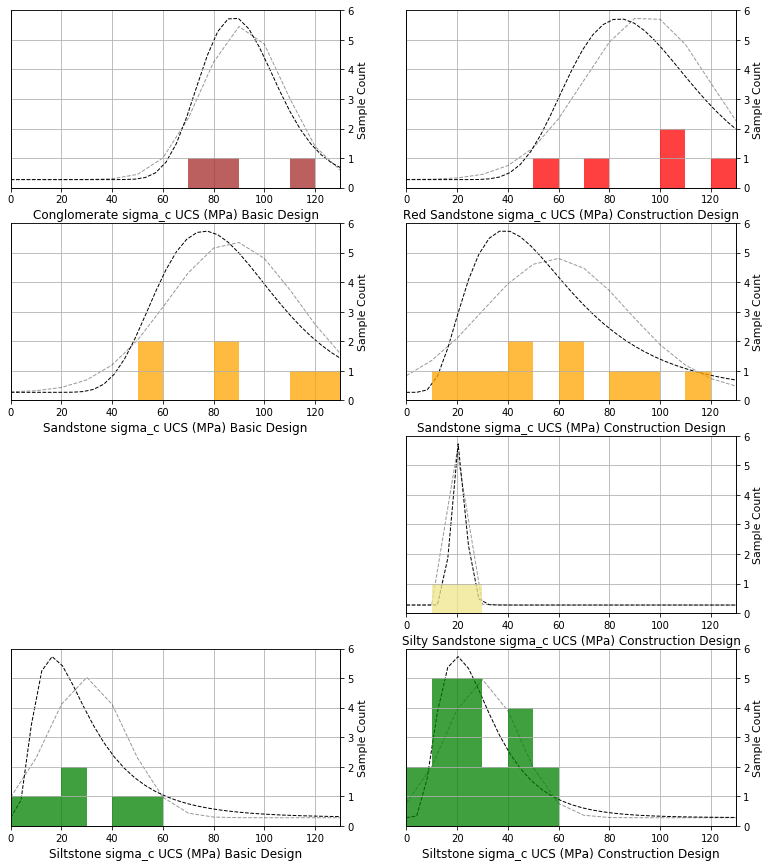

In [29]:
# plot histogram of all sigma_c values for selected lithologies 
# input: dict_sigma_c_const, dict_sigma_c_basic containing 'values' of 'parameter' sigma_c
# adjust: bins,ylim,xlim,xfit,ax1.set_xlabel,display(HTML)

sample_statistics=[]
fitted_norm_dist_parameters=[]
fitted_lognorm_dist_parameters=[]
confidence_limits_norm_dist=[]
    
def histogram_by_lithology(dict, lithology, sample_description):
    # plot histogram for values of selected lithology 
    ax2 = ax1.twinx()
    hist,bin_edges,patches = ax2.hist(dict[lithology],bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130],
                                      normed=0,facecolor=colors[lithology],alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)
    ax2.set_ylim(0,6)
    ax2.set_xlim(0,130)

    # plot normal distribution of values using scipy
    param = norm.fit(dict[lithology])  #param[0] and param[1] are mean and standard deviation
    y = mlab.normpdf( bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'k--', linewidth=1, alpha=0.4)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # plot lognormal distribution of E values using scipy  #use of lognorm.fit to be checked!             #ToDo JK
    shape, loc, scale = lognorm.fit(dict[lithology],floc=0)  #mu=log(scale), sigma=shape
    # floc=0 -> equivalent to fitting log(data) using stats.norm.fit, e.g. takes care of log transformation
    fitted_lognorm_mean=exp(np.log(scale)+shape**2/2)  #reference: wikipedia.org/wiki/Log-normal_distribution 
    fitted_lognorm_median=scale  #reference as above
    fitted_lognorm_mode=exp(np.log(scale)-shape**2)  #reference as above
    fitted_lognorm_var=(exp(shape**2)-1)*exp(2*np.log(scale)+shape**2)  #reference as above
    lognorm_ci_90 = lognorm.interval(0.90, shape, loc, scale)  #endpoints of range containing 90% of distribution
    fitted_lognorm_fract_5 = lognorm_ci_90[0]  #5% fractile (= lower endpoint of 90% confidence interval)
    x_fit = np.linspace(0,200,50)
    y = lognorm.pdf(x_fit, shape, loc, scale)
    ll = ax1.plot(x_fit, y, 'k--', linewidth=1)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # sample statistics
    sample_count=len(dict[lithology])  #n
    sample_mean=np.mean(dict[lithology])
    sample_median=np.median(dict[lithology])
    sample_skew=stats.skew(dict[lithology])
    sample_std_dev=np.std(dict[lithology])
    sample_statistics.append((lithology,
                          str(sample_count),
                          str(format(sample_mean,'.0f')),
                          str(format(sample_median,'.0f')),
                          str(format(sample_skew,'.2f')),
                          #str(format(sample_mode,'.0f')),
                          str(format(sample_std_dev,'.0f'))))
    
    # fitted normal distribution parameters
    fitted_norm_mean = param[0]  #mean of fitted distribution
    fitted_norm_std_dev = param[1]  #standard deviation of fitted distribution
    fitted_norm_conf_limit = fitted_norm_mean - fitted_norm_std_dev*1.645  #5% fractile (of 90% confidence interval)
    fitted_norm_dist_parameters.append((lithology,
                       str(format(fitted_norm_mean,'.0f')),  
                       str(format(fitted_norm_std_dev,'.0f')),
                       str(format(fitted_norm_conf_limit,'.0f'))))

    # confidence interval to normal distribution considering sampling
    confidence_limit_t = stats.t.ppf(1-0.05, sample_count-1)  #t-dist one-sided lower 95% confidence limit
    confidence_limit_chi2 = stats.chi2.ppf(0.05,sample_count-1)  #one-sided chi-square upper 95% confidence limit
    confidence_limit_mean = fitted_norm_mean-fitted_norm_std_dev*confidence_limit_t/sqrt(sample_count)
    confidence_limit_std_dev = sqrt(sample_count/confidence_limit_chi2)*fitted_norm_std_dev
    confidence_limits_norm_dist.append((lithology,
                       str(sample_count),  #sample count
                       str(format(confidence_limit_mean,'.0f')),  #95% lower confidence limit of mean
                       str(format(confidence_limit_std_dev,'.0f'))))  #95% upper confidence limit of std_dev

    # fitted lognormal distribution parameters
    fitted_lognorm_dist_parameters.append((lithology,
                        str(format(fitted_lognorm_mean,'.0f')),
                        str(format(fitted_lognorm_median,'.0f')),
                        str(format(fitted_lognorm_mode,'.0f')),                       
                        str(format(sqrt(fitted_lognorm_var),'.0f')),  #standard deviation
                        str(format(fitted_lognorm_fract_5,'.0f'))))  #95% confidence interval
    
    # plot axis labels and grid
    ax1.set_xlabel(lithology+' sigma_c UCS (MPa) '+sample_description,fontsize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)  
    ax1.axes.get_yaxis().set_ticks([])  #supress pdf lables on left y-axis
    ax1.grid(True); ax2.grid(True)

# report sample statistics
def report_sample_statistics(project_phase):  #
    sample_statistics_df = pd.DataFrame(data=sample_statistics)
    sample_statistics_df.columns = [u'Lithology', u'count', u'mean (MPa)', u'median (MPa)', u'skew',
                                    u'standard deviation (MPa)']
    display(HTML('<h4>Sample statistics of sigma_c values - '
                 +project_phase+'</h3>'))
    display(HTML(sample_statistics_df.to_html()))

# report fitted normal distribution parameters
def report_fitted_norm_dist_parameters(project_phase):  #fitted_norm_dist_parameters
    fitted_norm_dist_parameters_df = pd.DataFrame(data=fitted_norm_dist_parameters)
    fitted_norm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'standard deviation (MPa)', 
                                              u'95% CI (MPa)']
    display(HTML('<h4>Parameters of normal distribution fitted to sampled sigma_c values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_norm_dist_parameters_df.to_html(
                 formatters={'mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

# report confidence intervals considering sampling
def report_confidence_limits_norm_dist(project_phase):  #
    confidence_limits_norm_dist_df = pd.DataFrame(data=confidence_limits_norm_dist)
    confidence_limits_norm_dist_df.columns = [u'Lithology', u'count', 
                                    u'95% CI of mean (MPa)', u'95% CI of std_dev (MPa)']
    display(HTML('<h4>Confidence intervals of testing against normal distribution of sigma_c values - '
                 +project_phase+'</h3>'))
    display(HTML(confidence_limits_norm_dist_df.to_html(
                 formatters={'count':lambda x: '<strong>%s</strong>' %x,
                             '95% CI of mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

def report_fitted_lognorm_dist_parameters(project_phase):
    fitted_lognorm_dist_parameters_df = pd.DataFrame(data=fitted_lognorm_dist_parameters)
    fitted_lognorm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'median (MPa)', u'mode (MPa)', 
                                                 u'standard deviation (MPa)', u'95% CI (MPa)']
    display(HTML('<h4>Parameters of lognormal distribution fitted to sampled sigma_c values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_lognorm_dist_parameters_df.to_html()))


fig = plt.figure(figsize=(13,15))
ax1 = fig.add_subplot(4, 2, 2)
histogram_by_lithology(dict_sigma_c_const, 'Red Sandstone', 'Construction Design')
ax1 = fig.add_subplot(4, 2, 8)
histogram_by_lithology(dict_sigma_c_const, 'Siltstone', 'Construction Design')
ax1 = fig.add_subplot(4, 2, 6)
histogram_by_lithology(dict_sigma_c_const, 'Silty Sandstone', 'Construction Design')
ax1 = fig.add_subplot(4, 2, 4)
histogram_by_lithology(dict_sigma_c_const, 'Sandstone', 'Construction Design')
report_sample_statistics('Construction Design')
report_fitted_norm_dist_parameters('Construction Design')
report_confidence_limits_norm_dist('Construction Design')
report_fitted_lognorm_dist_parameters('Construction Design')

sample_statistics=[]
fitted_norm_dist_parameters=[]
confidence_limits_norm_dist=[]
fitted_lognorm_dist_parameters=[]
ax1 = fig.add_subplot(4, 2, 3)
histogram_by_lithology(dict_sigma_c_basic, 'Sandstone', 'Basic Design')
ax1 = fig.add_subplot(4, 2, 7)
histogram_by_lithology(dict_sigma_c_basic, 'Siltstone', 'Basic Design')
ax1 = fig.add_subplot(4, 2, 1)
histogram_by_lithology(dict_sigma_c_basic, 'Conglomerate', 'Basic Design')
report_sample_statistics('Basic Design')
report_fitted_norm_dist_parameters('Basic Design')
report_confidence_limits_norm_dist('Basic Design')
report_fitted_lognorm_dist_parameters('Basic Design')
plt.show()

## p-q plot for sigma_c and tau data

In [30]:
# select sigma_c (uniaxial and triaxial compression) and tau (direct shear) values for selected lithologies
# sample_desciption is used to store construction phase (phase hould be added to parameter metadata)       #ToDo JK 

tests={'ucs':data_sigma_c,'tx':data_sigma_c,'ds':data_tau}  #test types and input data for each test type
test_names={'ucs':'Uniaxial compression','tx':'Triaxial compression','ds':'Direct shear'}  #for selecting test_type
lithologies=('Red Sandstone','Sandstone','Siltstone','Conglomerate','Mudstone','Sheared Mudstone','Clay',
             'Silty Sandstone')
sig1_const = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_const = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
sig1_basic = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
                                
selected_strengths('Construction Design', sig1_const, sig3_const) 
selected_strengths('Basic Design', sig1_basic, sig3_basic)            

def count_selected_strengths(sig1,description):  #counts for data checking
    for item in sig1: 
        count=0
        for lithology,value in sig1[item].items():
            item_len = len(sig1[item][lithology])
            count = count + item_len
            if item_len > 1:
                print(description+':   count for selected '+str(item)+' in '+str(lithology)+': '+str(item_len))
        print (description+': count for selected '+str(item)+': '+str(count)) 

count_selected_strengths(sig1_const,'Construction Design')
count_selected_strengths(sig1_basic,'Basic Design')

#print sig1_const['ucs']['Siltstone']
#print sig1_const['tx']
#print sig3_const['tx']

Construction Design:   count for selected ucs in Silty Sandstone: 2
Construction Design:   count for selected ucs in Sandstone: 10
Construction Design:   count for selected ucs in Red Sandstone: 5
Construction Design:   count for selected ucs in Siltstone: 20
Construction Design: count for selected ucs: 37
Construction Design:   count for selected ds in Sheared Mudstone: 24
Construction Design:   count for selected ds in Sandstone: 24
Construction Design:   count for selected ds in Siltstone: 15
Construction Design:   count for selected ds in Clay: 12
Construction Design: count for selected ds: 75
Construction Design:   count for selected tx in Red Sandstone: 6
Construction Design:   count for selected tx in Siltstone: 9
Construction Design:   count for selected tx in Mudstone: 2
Construction Design: count for selected tx: 17
Basic Design:   count for selected ucs in Sandstone: 6
Basic Design:   count for selected ucs in Siltstone: 6
Basic Design:   count for selected ucs in Conglomera

slope: 0.8988808238409681    intercept: 2.235866675534538
phi: 64.0113442601    c: 5.102467972258814
slope: 0.8457205294104347    intercept: 1.6049512063180345
phi: 57.7492170132    c: 3.0076326599138925
slope: 0.8189225894069715    intercept: 3.2200090538705304
phi: 54.9770858033    c: 5.610710321217026


,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Red Sandstone,5.102,64.0,55.6,76.5,0.04,1.00,0.00004
1,Siltstone,3.008,57.7,45.1,79.4,0.08,0.97,0.00002
2,Mudstone,5.611,55.0,55.0,55.0,0.00,1.00,0.00000


slope: 0.9182314395383612    intercept: -0.32247208102773683
phi: 66.6688847452    c: -0.8142325162600842


,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Siltstone,-0.814,66.7,59.9,76.2,0.03,1.00,0.00000


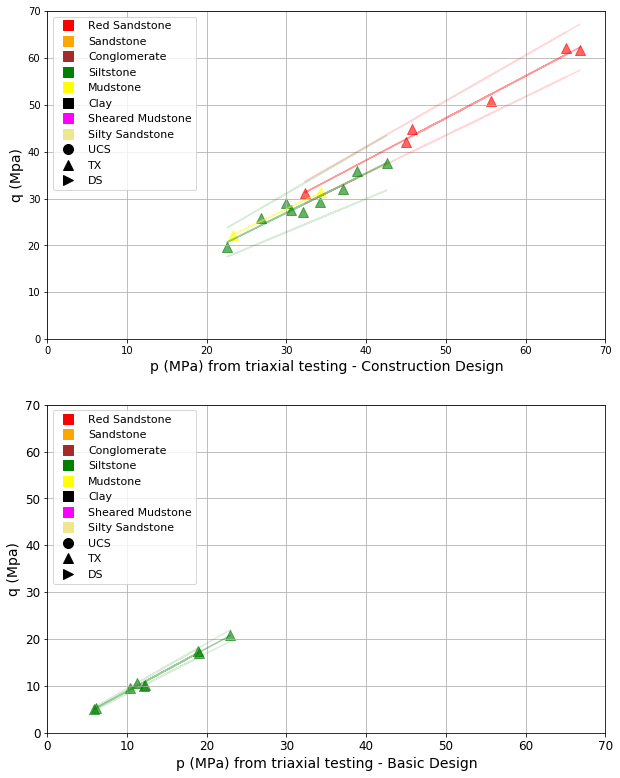

In [31]:
# p-q plot for sigma_c and tau data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'

statistics=[]

def pq_plot(sig1, sig3, lithology, test, sample_description):
# p-q plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    #statistics=[]
    #if test=='ucs' or test=='tx':
    if test=='ucs':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    if test=='tx':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept            
            line_upper = (slope+std_err*1.645)*s1+intercept
            line_lower = (slope-std_err*1.645)*s1+intercept
                                    
            #calculate c and phi from intercept and slope (a and alpha in p-q space) of trend lines
            print('slope: '+str(slope)+'    intercept: '+str(intercept))
            phi=asin(slope) #slope=tan(alpha)
            c=intercept/cos(phi)
            print('phi: '+str(degrees(phi))+'    c: '+str(c))
            
            statistics.append((lithology,
                              str(format(c,'.3f')),
                              str(format(degrees(phi),'.1f')),
                              str(format(degrees(asin(slope-std_err*1.645)),'.1f')),
                              str(format(degrees(asin(slope+std_err*1.645)),'.1f')),  #check for slope+std_err >1
                              str(format(std_err,'.2f')),                                               #ToDo JK
                              str(format(r_value,'.2f')),str(format(p_value,'.5f'))))
            
            plt.plot(s1,line, color=colors[lithology],alpha=0.4)
            plt.plot(s1,line_upper, color=colors[lithology],alpha=0.15)
            plt.plot(s1,line_lower, color=colors[lithology],alpha=0.15)            
            #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    if test=='ds':
        plt.scatter(rand_jitter(sig3_),rand_jitter(sig1_),
                    marker=markers[test],s= 150.,facecolor=colors[lithology],alpha=0.6)
        if not sig1_.any():  #if no data for lithology  --> mv this above plt.scatter                      #ToDo JK
            pass
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(sig3_,sig1_)
            line = slope*sig3_+intercept             
        plt.plot(sig3_,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    plt.ylabel('q (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('p (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

# display derived parameters and statistics
def plot_statistics(project_phase):
    statistics_df = pd.DataFrame(data=statistics)
    statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                             u'std_err', u'correlation', u'p_value']
    display(HTML('<h4>Derived c, phi and statistics of plotted p-q values from triaxial testing - '
                 +project_phase+'</h3>'))
    display(HTML(statistics_df.to_html()))
    

plt.figure(figsize=(10, 35))

#plt.subplot(511)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    pq_plot(sig1_const['ucs'], sig3_const['ucs'],lithology,'ucs','Construction Design')
##for lithology in lithologies:
##    pq_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
#legend()

plt.subplot(511)
plt.xlim((0,70))
plt.ylim((0,70))
for lithology in lithologies:
    pq_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
legend_for_litholgies_tests("upper left")
plot_statistics('Construction Design')

#plt.subplot(513)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    pq_plot(sig1_basic['ucs'], sig3_basic['ucs'],lithology,'ucs','Basic Design')
##for lithology in lithologies:
##    pq_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
#legend()

plt.subplot(512)
plt.xlim((0,70))
plt.ylim((0,70))
statistics=[]  #set list for HTML table to null
for lithology in lithologies:
    pq_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
legend_for_litholgies_tests("upper left")
plot_statistics('Basic Design')

#plt.subplot(515)
#plt.xlim((0,3))
#plt.ylim((0,3))
#for lithology in lithologies:
#    pq_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
#plt.ylabel('tau (Mpa)',fontsize=14)
#plt.xlabel('sigma_v (MPa) Construction Design',fontsize=14)
#legend()    

plt.show()

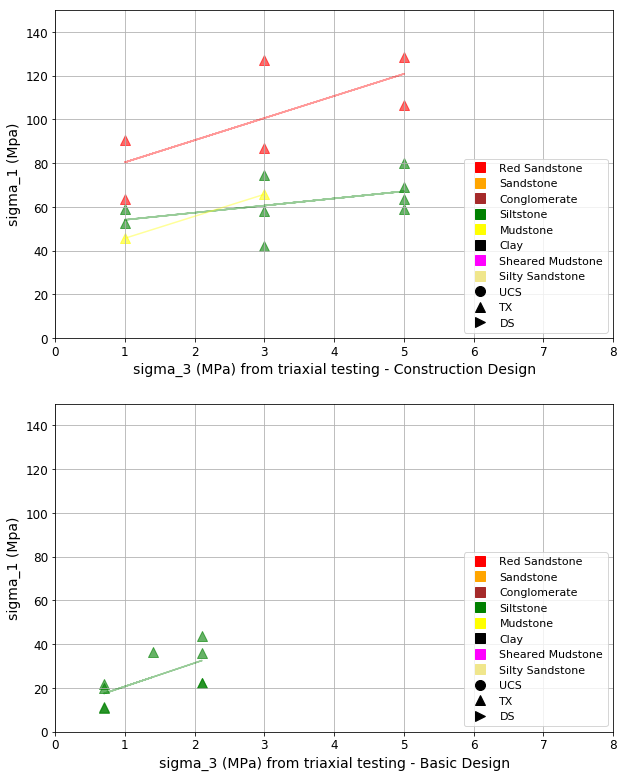

In [32]:
# sig1 vs sig3 plot for TX sigma_c data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'
# ADJUST: project phases, lithologies (above), plots: xlimit, ylimit, legend

def s1s3_plot(sig1, sig3, lithology, test, sample_description):
# sig1-sig3 plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.

    if test=='tx':
        plt.scatter(sig3_, sig1_,
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=sig1_
            s3=sig3_
            slope, intercept, r_value, p_value, std_err = stats.linregress(s3,s1)
            line = slope*s3+intercept
        plt.plot(s3,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    plt.ylabel('sigma_1 (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('sigma_3 (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

#plt.subplot(511)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    s1s3_plot(sig1_const['ucs'], sig3_const['ucs'],lithology,'ucs','Construction Design')
##for lithology in lithologies:
##    s1s3_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
#legend()

plt.subplot(511)
plt.xlim((0,8))
plt.ylim((0,150))
for lithology in lithologies:
    s1s3_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
legend_for_litholgies_tests("lower right")

#plt.subplot(513)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    s1s3_plot(sig1_basic['ucs'], sig3_basic['ucs'],lithology,'ucs','Basic Design')
##for lithology in lithologies:
##    s1s3_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
#legend()

plt.subplot(512)
plt.xlim((0,8))
plt.ylim((0,150))
for lithology in lithologies:
    s1s3_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
legend_for_litholgies_tests("lower right")
#plt.subplot(515)
#plt.xlim((0,3))
#plt.ylim((0,3))
#for lithology in lithologies:
#    s1s3_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
#plt.ylabel('tau (Mpa)',fontsize=14)
#plt.xlabel('sigma_v (MPa) Construction Design',fontsize=14)
#legend()    

plt.show()

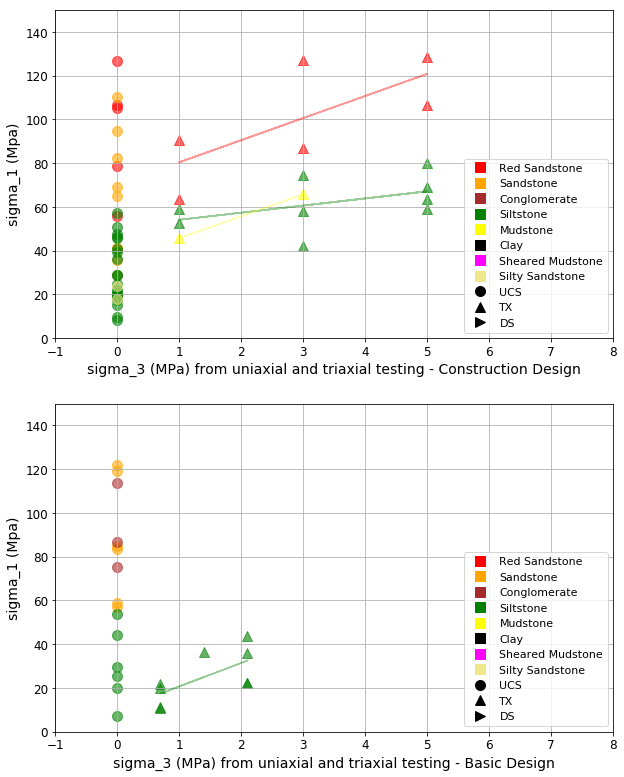

In [33]:
# sig1 vs sig3 plot for UCS and TX sigma_c data for all rock lithologies
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'
# ADJUST: project phases, lithologies (above), plots: xlimit, ylimit, legend

def s1s3_plot(sig1, sig3, lithology, test, sample_description):
# sig1-sig3 plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    if test=='ucs' or test=='tx':
        plt.scatter(sig3_, sig1_,
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=sig1_
            s3=sig3_
            slope, intercept, r_value, p_value, std_err = stats.linregress(s3,s1)
            line = slope*s3+intercept
        plt.plot(s3,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    plt.ylabel('sigma_1 (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('sigma_3 (MPa) from uniaxial and triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

plt.subplot(511)
plt.xlim((-1,8))
plt.ylim((0,150))
for lithology in lithologies:
    s1s3_plot(sig1_const['ucs'], sig3_const['ucs'],lithology,'ucs','Construction Design')
for lithology in lithologies:    
    s1s3_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
#for lithology in lithologies:
legend_for_litholgies_tests("lower right")

plt.subplot(512)
plt.xlim((-1,8))
plt.ylim((0,150))
for lithology in lithologies:
    s1s3_plot(sig1_basic['ucs'], sig3_basic['ucs'],lithology,'ucs','Basic Design')
for lithology in lithologies:
    s1s3_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
legend_for_litholgies_tests("lower right")

plt.show()

In [34]:
# query Data Organizer records for 'parameter' = tau
# sorting by borehole_code and sample_depth

# initialize variables
data_tau=[]

parameter = 'tau'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1.r2','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3    #ToDo JK

    if rec['measurement_convention'] == 'Peak strength':  #tmp - should handled in plot data              #ToDo JK
      data_tau.append(rec)
    
print('count for tau: '+str(len(data_tau)))    # record count for checking

count for tau: 57


In [35]:
# select sigma_c (uniaxial and triaxial compression) and tau (direct shear) values for selected lithologies
# sample_desciption is used to store construction phase (phase hould be added to parameter metadata)       #ToDo JK 

tests={'ucs':data_sigma_c,'tx':data_sigma_c,'ds':data_tau}  #test types and input data for each test type
test_names={'ucs':'Uniaxial compression','tx':'Triaxial compression','ds':'Direct shear'}  #for selecting test_type
lithologies=('Red Sandstone','Sandstone','Siltstone','Conglomerate','Mudstone','Sheared Mudstone','Clay',
             'Silty Sandstone')
sig1_const = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_const = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
sig1_basic = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
                                
selected_strengths('Construction Design', sig1_const, sig3_const) 
selected_strengths('Basic Design', sig1_basic, sig3_basic)            

def count_selected_strengths(sig1,description):  #counts for data checking
    for item in sig1: 
        count=0
        for lithology,value in sig1[item].items():
            item_len = len(sig1[item][lithology])
            count = count + item_len
            if item_len > 1:
                print(description+':   count for selected '+str(item)+' in '+str(lithology)+': '+str(item_len))
        print (description+': count for selected '+str(item)+': '+str(count)) 

count_selected_strengths(sig1_const,'Construction Design')
count_selected_strengths(sig1_basic,'Basic Design')

#print sig1_const['ucs']['Siltstone']
#print sig1_const['tx']
#print sig3_const['tx']

Construction Design:   count for selected ucs in Silty Sandstone: 2
Construction Design:   count for selected ucs in Sandstone: 10
Construction Design:   count for selected ucs in Red Sandstone: 5
Construction Design:   count for selected ucs in Siltstone: 20
Construction Design: count for selected ucs: 37
Construction Design:   count for selected ds in Sheared Mudstone: 12
Construction Design:   count for selected ds in Sandstone: 24
Construction Design:   count for selected ds in Siltstone: 15
Construction Design:   count for selected ds in Clay: 6
Construction Design: count for selected ds: 57
Construction Design:   count for selected tx in Red Sandstone: 6
Construction Design:   count for selected tx in Siltstone: 9
Construction Design:   count for selected tx in Mudstone: 2
Construction Design: count for selected tx: 17
Basic Design:   count for selected ucs in Sandstone: 6
Basic Design:   count for selected ucs in Siltstone: 6
Basic Design:   count for selected ucs in Conglomerat

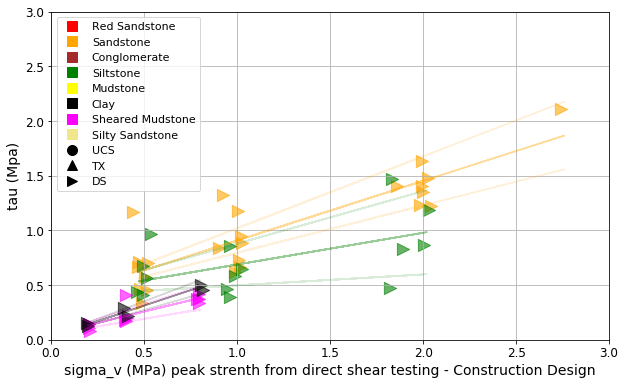

In [36]:
# p-q plot for sigma_c and tau data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'

statistics=[]

def pq_plot(sig1, sig3, lithology, test, sample_description):
# p-q plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    #if test=='ucs' or test=='tx':
    if test=='ucs':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    if test=='tx':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    if test=='ds':
        plt.scatter(rand_jitter(sig3_),rand_jitter(sig1_),
                    marker=markers[test],s= 150.,facecolor=colors[lithology],alpha=0.6)
        if not sig1_.any():  #if no data for lithology  --> mv this above plt.scatter                      #ToDo JK
            pass
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(sig3_,sig1_)
            line = slope*sig3_+intercept            
            line_upper = (slope+std_err*1.645)*sig3_+intercept
            line_lower = (slope-std_err*1.645)*sig3_+intercept
            plt.plot(sig3_,line, color=colors[lithology],alpha=0.4)
            plt.plot(sig3_,line_upper, color=colors[lithology],alpha=0.15)
            plt.plot(sig3_,line_lower, color=colors[lithology],alpha=0.15)
            #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

            statistics.append((lithology,
                              str(format(intercept,'.3f')),
                              str(format(degrees(atan(slope)),'.1f')),
                              str(format(degrees(atan(slope-std_err*1.645)),'.1f')),
                              str(format(degrees(atan(slope+std_err*1.645)),'.1f')),
                              str(format(std_err,'.2f')),
                              str(format(r_value,'.2f')),str(format(p_value,'.5f'))))
            
    plt.ylabel('q (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('p (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

plt.subplot(511)
plt.xlim((0,3))
plt.ylim((0,3))
for lithology in lithologies:
    pq_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
plt.ylabel('tau (Mpa)',fontsize=14)
plt.xlabel('sigma_v (MPa) peak strenth from direct shear testing - Construction Design',fontsize=14)
legend_for_litholgies_tests("upper left")    

plt.show()

In [37]:
# display derived parameters and statistics
statistics_df = pd.DataFrame(data=statistics)
statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                         u'std_err', u'correlation', u'p_value']
display(HTML('<h4>Derived c, phi and statistics of plotted values from direct shear testing - peak strength</h3>'))
display(HTML(statistics_df.to_html()))  

,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Sandstone,0.361,28.6,23.4,33.3,0.07,0.86,0.00000
1,Siltstone,0.397,16.2,5.7,25.7,0.12,0.57,0.02620
2,Sheared Mudstone,0.050,22.5,15.8,28.6,0.08,0.85,0.00042
3,Clay,0.028,29.5,26.0,32.8,0.05,0.99,0.00030


In [38]:
# query Data Organizer records for 'parameter' = tau
# sorting by borehole_code and sample_depth

# initialize variables
data_tau=[]

parameter = 'tau'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1.r2','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3    #ToDo JK

    if rec['measurement_convention'] == 'Residual strength':  #tmp - should handled in plot data              #ToDo JK
      data_tau.append(rec)
    
print('count for tau: '+str(len(data_tau)))    # record count for checking

count for tau: 18


In [39]:
# select sigma_c (uniaxial and triaxial compression) and tau (direct shear) values for selected lithologies
# sample_desciption is used to store construction phase (phase hould be added to parameter metadata)       #ToDo JK 

tests={'ucs':data_sigma_c,'tx':data_sigma_c,'ds':data_tau}  #test types and input data for each test type
test_names={'ucs':'Uniaxial compression','tx':'Triaxial compression','ds':'Direct shear'}  #for selecting test_type
lithologies=('Red Sandstone','Sandstone','Siltstone','Conglomerate','Mudstone','Sheared Mudstone','Clay',
             'Silty Sandstone')
sig1_const = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_const = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
sig1_basic = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
                                
selected_strengths('Construction Design', sig1_const, sig3_const) 
selected_strengths('Basic Design', sig1_basic, sig3_basic)            

def count_selected_strengths(sig1,description):  #counts for data checking
    for item in sig1: 
        count=0
        for lithology,value in sig1[item].items():
            item_len = len(sig1[item][lithology])
            count = count + item_len
            if item_len > 1:
                print(description+':   count for selected '+str(item)+' in '+str(lithology)+': '+str(item_len))
        print (description+': count for selected '+str(item)+': '+str(count)) 

count_selected_strengths(sig1_const,'Construction Design')
count_selected_strengths(sig1_basic,'Basic Design')

#print sig1_const['ucs']['Siltstone']
#print sig1_const['tx']
#print sig3_const['tx']

Construction Design:   count for selected ucs in Silty Sandstone: 2
Construction Design:   count for selected ucs in Sandstone: 10
Construction Design:   count for selected ucs in Red Sandstone: 5
Construction Design:   count for selected ucs in Siltstone: 20
Construction Design: count for selected ucs: 37
Construction Design:   count for selected ds in Sheared Mudstone: 12
Construction Design:   count for selected ds in Clay: 6
Construction Design: count for selected ds: 18
Construction Design:   count for selected tx in Red Sandstone: 6
Construction Design:   count for selected tx in Siltstone: 9
Construction Design:   count for selected tx in Mudstone: 2
Construction Design: count for selected tx: 17
Basic Design:   count for selected ucs in Sandstone: 6
Basic Design:   count for selected ucs in Siltstone: 6
Basic Design:   count for selected ucs in Conglomerate: 3
Basic Design: count for selected ucs: 15
Basic Design: count for selected ds: 0
Basic Design:   count for selected tx i

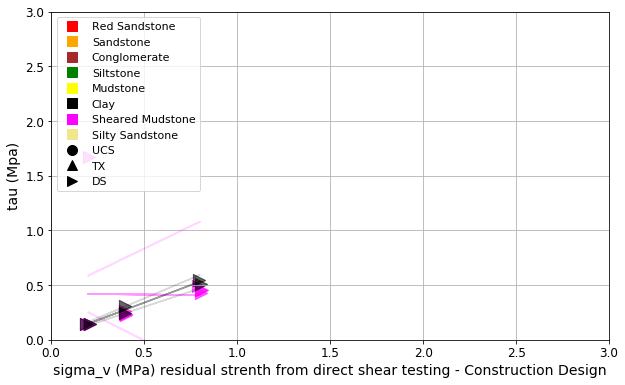

In [40]:
# p-q plot for sigma_c and tau data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'

statistics=[]

def pq_plot(sig1, sig3, lithology, test, sample_description):
# p-q plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    #if test=='ucs' or test=='tx':
    if test=='ucs':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    if test=='tx':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    if test=='ds':
        plt.scatter(rand_jitter(sig3_),rand_jitter(sig1_),
                    marker=markers[test],s= 150.,facecolor=colors[lithology],alpha=0.6)
        if not sig1_.any():  #if no data for lithology  --> mv this above plt.scatter                      #ToDo JK
            pass
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(sig3_,sig1_)
            line = slope*sig3_+intercept
            line_upper = (slope+std_err*1.645)*sig3_+intercept
            line_lower = (slope-std_err*1.645)*sig3_+intercept
            plt.plot(sig3_,line, color=colors[lithology],alpha=0.4)
            plt.plot(sig3_,line_upper, color=colors[lithology],alpha=0.15)
            plt.plot(sig3_,line_lower, color=colors[lithology],alpha=0.15)

            display(HTML(test+':  '+lithology+'  '+'cohesion intercept: '+str(format(intercept,'.3f'))
                    +'  friction slope: '+str(format(degrees(atan(slope)),'.1f'))
                    +'  friction slope lower: '+str(format(degrees(atan(slope-std_err*1.645)),'.1f'))
                    +'  friction slope upper: '+str(format(degrees(atan(slope+std_err*1.645)),'.1f'))
                    #90% confidence_interval = 1.645*std_err  #en.wikipedia.org/wiki/Confidence_interval#Basic_Steps
                    +'  std_err: '+str(format(std_err,'.2f'))  #standard error of the estimated slope
                    +'  r_value: '+str(format(r_value,'.2f'))  #correlation coefficient
                    +'  p_value: '+str(format(p_value,'.5f'))))#two-sided p-value for a hypothesis test whose 
                                                               #null hypothesis is that the slope is zero,using 
                                                               #Wald Test with t-distribution of the test statistic

            statistics.append((lithology,
                              str(format(intercept,'.3f')),
                              str(format(degrees(atan(slope)),'.1f')),
                              str(format(degrees(atan(slope-std_err*1.645)),'.1f')),
                              str(format(degrees(atan(slope+std_err*1.645)),'.1f')),
                              str(format(std_err,'.2f')),
                              str(format(r_value,'.2f')),str(format(p_value,'.5f'))))
             
    plt.ylabel('q (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('p (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

plt.subplot(511)
plt.xlim((0,3))
plt.ylim((0,3))
for lithology in lithologies:
    pq_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
plt.ylabel('tau (Mpa)',fontsize=14)
plt.xlabel('sigma_v (MPa) residual strenth from direct shear testing - Construction Design',fontsize=14)
legend_for_litholgies_tests("upper left")    

plt.show()

In [41]:
# display derived parameters and statistics
statistics_df = pd.DataFrame(data=statistics)
statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                         u'std_err', u'correlation', u'p_value']
display(HTML('<h4>Derived c, phi and statistics of plotted values from direct shear testing - residual strength</h3>'))
display(HTML(statistics_df.to_html()))  

,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Sheared Mudstone,0.421,-1.0,-40.6,39.4,0.51,-0.01,0.97412
1,Clay,0.018,32.7,29.4,35.7,0.05,0.99,0.00017


## Scatterplot of uniaxial testing data E50 vs sigma_c

In [42]:
# remove records for sigma_c if no record for E at the sample_depth, for scatterplot
# note: it is not checked here if E and sigma_c have valid data at borehole/sample_depth locations
# input: data_E, data_sigma_c

data_sigma_c_adj=[]  # adjusted lists containing uniaxial testing records
data_E_adj=[]
data_sigma_c_adj_loc=[] # adjusted lists containing borehole/sample_depth locations
data_E_adj_loc=[]

i=0

for item in data_sigma_c:
    if item['test_type'] == 'Uniaxial compression':
        data_sigma_c_adj.append(item)
        data_sigma_c_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
for item in data_E:
    if item['test_type'] == 'E measured during uniaxial compression':
        data_E_adj.append(item)
        data_E_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
            
data_check = set(data_sigma_c_adj_loc).intersection(data_E_adj_loc)  #unique pairs of intersection of lists
        
# quick list of borehole/sample detpoh data records in data_sigma_c that are also in data_E:
    # check if a record exists with an E value at the sample_depth of the item
    # and append to the adjusted list if record exists 
    #if any(d['sample_depth_top_m'] == (data_sigma_c[i]['sample_depth_top_m']) for d in data_E):
    #    #print data_sigma_c[i]['borehole_code']
    #    #add if test_type = 'Uniaxial compression' (and add similar adjustment for E)                 #ToDo  JK
    #    data_sigma_c_adj.append(item)
    #    i+=1
    #else:
    #    i=1+i
    #    pass

# check record counts
print(len(data_sigma_c))
print(len(data_sigma_c_adj))
print(len(data_E))
print(len(data_E_adj))

78
52
68
48


In [50]:
type(data_sigma_c)

list

In [43]:
# testing of data sets used for scatterplot
data_check = set(data_sigma_c_adj_loc).intersection(data_E_adj_loc)  #unique pairs of intersection of lists
print 'data_check:',len(data_check)
set(data_sigma_c_adj_loc) & set(data_E_adj_loc)
print 'length: intersection of both data sets:',len(set(data_sigma_c_adj_loc) & set(data_E_adj_loc))
[name for name in data_sigma_c_adj_loc if name in data_E_adj_loc]
print 'legnth: if name in both data sets', len([name for name in data_sigma_c_adj_loc if name in data_E_adj_loc])
print 'difference between data sets', set(data_sigma_c_adj_loc).difference(data_E_adj_loc)

data_check: 40
length: intersection of both data sets: 40
legnth: if name in both data sets 49
difference between data sets set([(u'NT1-LB-ExpAdit', u'22.00'), (u'NT1-5', u'24.25')])


In [44]:
# display record of scatterplot data
# input: data_E_adj, data_sigma_c_adj
data_scatterplot=[]
for i in range(len(data_E_adj)):
    data_scatterplot.append((data_sigma_c_adj[i]['borehole_code'],data_sigma_c_adj[i]['sample_depth_top_m'],
          float(data_E_adj[i]['value']), float(data_sigma_c_adj[i]['value']),
          '{0:.0f}'.format(float(data_E_adj[i]['value'])/float(data_sigma_c_adj[i]['value'])),
          data_E_adj[i]['sample_description'],data_E_adj[i]['lithology']))
data_scatterplot_df = pd.DataFrame(data=data_scatterplot)
data_scatterplot_df.columns = [u'Borehole',u'Depth',u'E (MPa)',u'sigma_c (MPa)',u'Ratio E/sigma_c',
                               u'Sample',u'Lithology', ]
display(HTML('<h4>Selected data for scatterplot </h4>'))
display(HTML(data_scatterplot_df.to_html()))

,Borehole,Depth,E (MPa),sigma_c (MPa),Ratio E/sigma_c,Sample,Lithology
0,NT1-1,27.10,3352.0,86.82,39,Basic Design,Conglomerate
1,NT1-1,61.50,3532.0,75.15,47,Basic Design,Conglomerate
2,NT1-11,15.65,3142.0,85.02,37,Basic Design,Sandstone
3,NT1-14,28.90,13200.0,56.01,236,Construction Design,Red Sandstone
4,NT1-14,36.80,51400.0,106.68,482,Construction Design,Red Sandstone
5,NT1-14,37.30,19700.0,126.68,156,Construction Design,Red Sandstone
6,NT1-14,37.30,17800.0,78.68,226,Construction Design,Red Sandstone
7,NT1-14,56.80,22100.0,105.35,210,Construction Design,Red Sandstone
8,NT1-15,32.20,4170.0,20.67,202,Construction Design,Siltstone
9,NT1-15,54.20,31500.0,110.22,286,Construction Design,Sandstone


Construction Design  Red Sandstone  intercept: 76.19902731682409  slope: 0.0007440005105948431  error: 0.0009535378725538106
Construction Design  Sandstone  intercept: 29.82151330039135  slope: 0.0026216731771187374  error: 0.0009148806598319926
Construction Design  Siltstone  intercept: 24.616622771004742  slope: 0.0011529683437083052  error: 0.0009148010734652177
Construction Design  Silty Sandstone  intercept: 26.23369369369369  slope: -0.0010090090090090085  error: 0.0
Basic Design  Sandstone  intercept: 69.86079833225854  slope: 0.004710791662447633  error: 0.017186173350484047
Basic Design  Siltstone  intercept: 8.588881574743347  slope: 0.02081920681177685  error: 0.03266820924051545
Basic Design  Conglomerate  intercept: 203.60623862741858  slope: -0.0355776140489223  error: 0.003138689125348564


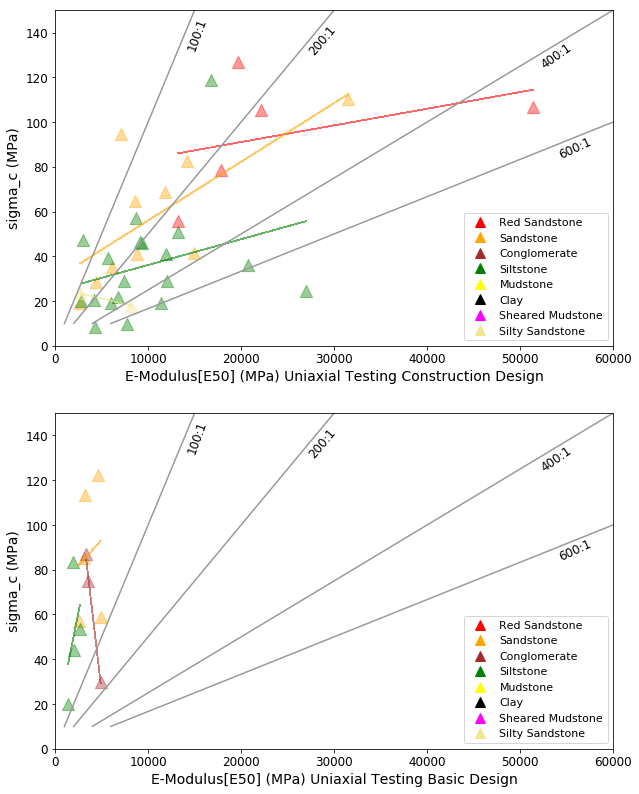

In [45]:
# scatterplot of E50 against sigma_c for all rock lithologies
# input: data_E_adj, data_sigma_c_adj containing ordered 'values' of 'parameter' E and sigma_c,
#        ordering using 'borehole_code' and sample_depth_top_m
# prcocedure needs to berobust, check that correct ordered pairs are always plotted                       #ToDo JK

# lithologies: defined above 
E={}
sigma_c={}

# select E, sgima_c data pairs and write to dictionary
# select for construction phase implies that E and sigma_c values are both in same phase, correct?        #ToDo JK
def selected_pairs(sample_description):
    E.clear()
    sigma_c.clear()
    for lithology in lithologies:
        E[lithology]=[]  #initialize dictionary
        sigma_c[lithology]=[]  #initialize dictionary
    for i in range(len(data_E_adj)):
        if (data_E_adj[i]['value']) != 'NaN':  #ignore NaN values    
            if (data_E_adj[i]['sample_description']) == sample_description:  #select for phase
                for lithology in lithologies:  # select for lithology
                    if (data_E_adj[i]['lithology']) == lithology:
                        if float(data_E_adj[i]['value']):  #this is only check for E, not sigma_c         #ToDo JK
                            E[lithology].append(float(data_E_adj[i]['value']))
                            sigma_c[lithology].append(float(data_sigma_c_adj[i]['value']))

def scatter_plot(E_, sigma_c_, lithology, sample_description):
    if E_.any():  # if E values are present for a selected lithology
        # scatterplot for values of selected lithology
        plt.scatter(E_,sigma_c_,
                    marker='^',s= 150.,facecolor=colors[lithology],alpha=0.4)
        #calculate linear regression
        line=(); s1=(); s3=(); intercept=0.; slope=0.; std_err=0.
        slope, intercept, r_value, p_value, std_err = stats.linregress(E_,sigma_c_)
        line = slope*E_+intercept
        plt.plot(E_,line, color=colors[lithology],alpha=0.6,linewidth=0.8,antialiased=False)
        print(sample_description+'  '+lithology+'  '+
              'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

def legend():    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="magenta")
    sym8 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="khaki")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym8),
           ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone",
            "Silty Sandstone"),
             fontsize=11, numpoints=1,loc="lower right")

def trend():
# show a reference trend line
    plt.plot((1000,10000,20000,30000),(10,100,200,300),color='0.6')
    plt.annotate("100:1",xy=(14000,143),xytext=(14000,143),rotation=70,fontsize=12)
    plt.plot((2000,20000,40000,60000),(10,100,200,300),color='0.6')
    plt.annotate("200:1",xy=(27000,140),xytext=(27000,140),rotation=50,fontsize=12)
    plt.plot((4000,40000,60000),(10,100,150),color='0.6')
    plt.annotate("400:1",xy=(52000,132),xytext=(52000,132),rotation=35,fontsize=12)
    plt.plot((6000,60000),(10,100),color='0.6')
    plt.annotate("600:1",xy=(54000,90),xytext=(54000,90),rotation=25,fontsize=12)


plt.figure(figsize=(10, 21))

plt.subplot(311)
selected_pairs('Construction Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Construction Design')
    
plt.xlim((0,60000))
plt.ylim((0,150))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Uniaxial Testing Construction Design',fontsize=14)
trend()
legend()
# check plot values
#print E
#print sigma_c

plt.subplot(312)
selected_pairs('Basic Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Basic Design')

plt.xlim((0,60000))
plt.ylim((0,150))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Uniaxial Testing Basic Design',fontsize=14)
trend()
legend()
# check plot values
#print E
#print sigma_c

plt.show()

## Scatterplot of triaxial testing data E50 vs sigma_c

In [46]:
# remove records for sigma_c if no record for E at the sample_depth, for scatterplot
# note: it is not checked here if E and sigma_c have valid data at borehole/sample_depth locations
# input: data_E, data_sigma_c (ordered by borehole and sample depth)

data_sigma_c_adj=[]  # adjusted list with dictionaries containing triaxial testing records
data_E_adj=[]
data_sigma_c_adj_loc=[] # adjusted lists containing borehole/sample_depth locations
data_E_adj_loc=[]

i=0

# list with depth data records for data_sigma_c and data_E (presumes same reocord count for each data)
for item in data_sigma_c:
    if item['test_type'] == 'Triaxial compression':
        data_sigma_c_adj.append(item)
        data_sigma_c_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
for item in data_E:
    if item['test_type'] == 'E measured during triaxial compression':
        data_E_adj.append(item)
        data_E_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
            
data_check = set(data_sigma_c_adj_loc).intersection(data_E_adj_loc)  #unique pairs of intersection of lists
        
# list of borehole/sample depth data records in data_sigma_c that are also in data_E:
    # check if a record exists with an E value at the sample_depth of the item
    # and append to the adjusted list if record exists 
    #if any(d['sample_depth_top_m'] == (data_sigma_c[i]['sample_depth_top_m']) for d in data_E):
    #    #print data_sigma_c[i]['borehole_code']
    #    #add if test_type = 'Triaxial compression' (and add similar adjustment for E)                 #ToDo  JK
    #    data_sigma_c_adj.append(item)
    #    i+=1
    #else:
    #    i=1+i
    #    pass

# check record counts
print(len(data_sigma_c))
print(len(data_sigma_c_adj))
print(len(data_E))
print(len(data_E_adj))

78
26
68
20


In [47]:
# testing of data sets used for scatterplot
data_check = set(data_sigma_c_adj_loc).intersection(data_E_adj_loc)  #unique pairs of intersection of lists
print 'data_check:',len(data_check)
set(data_sigma_c_adj_loc) & set(data_E_adj_loc)
print 'length: intersection of both data sets:',len(set(data_sigma_c_adj_loc) & set(data_E_adj_loc))
[name for name in data_sigma_c_adj_loc if name in data_E_adj_loc]
print 'legnth: if name in both data sets', len([name for name in data_sigma_c_adj_loc if name in data_E_adj_loc])
print 'difference between data sets', set(data_sigma_c_adj_loc).difference(data_E_adj_loc)

data_check: 7
length: intersection of both data sets: 7
legnth: if name in both data sets 20
difference between data sets set([(u'NT1-14', u'57.85'), (u'NT1-14', u'28.90')])


In [48]:
# display record of scatterplot data
# input: data_E_adj, data_sigma_c_adj
data_scatterplot=[]
for i in range(len(data_E_adj)):
    data_scatterplot.append((data_sigma_c_adj[i]['borehole_code'],data_sigma_c_adj[i]['sample_depth_top_m'],
          float(data_E_adj[i]['value']), float(data_sigma_c_adj[i]['value']),
          '{0:.0f}'.format(float(data_E_adj[i]['value'])/float(data_sigma_c_adj[i]['value'])),
          data_E_adj[i]['sample_description'],data_E_adj[i]['lithology']))
data_scatterplot_df = pd.DataFrame(data=data_scatterplot)
data_scatterplot_df.columns = [u'Borehole',u'Depth',u'E (MPa)',u'sigma_c (MPa)',u'Ratio E/sigma_c',
                               u'Sample',u'Lithology', ]
display(HTML('<h4>Selected data for scatterplot </h4>'))
display(HTML(data_scatterplot_df.to_html()))

,Borehole,Depth,E (MPa),sigma_c (MPa),Ratio E/sigma_c,Sample,Lithology
0,NT1-14,28.90,8770.0,128.55,68,Construction Design,Mudstone
1,NT1-14,28.90,6830.0,90.54,75,Construction Design,Mudstone
2,NT1-14,28.90,7940.0,127.17,62,Construction Design,Siltstone
3,NT1-14,57.85,11800.0,63.58,186,Construction Design,Siltstone
4,NT1-14,57.85,9579.0,106.43,90,Construction Design,Siltstone
5,NT1-14,57.85,6867.0,87.08,79,Construction Design,Siltstone
6,NT1-15,31.90,3710.0,65.70,56,Construction Design,Siltstone
7,NT1-15,31.90,4130.0,45.61,91,Construction Design,Siltstone
8,NT1-15,32.20,8674.0,63.38,137,Construction Design,Siltstone
9,NT1-15,36.08,11660.0,80.17,145,Construction Design,Siltstone


Construction Design  Siltstone  intercept: 69.3055463564216  slope: 0.0008949529826308891  error: 0.003216287099152441
Construction Design  Mudstone  intercept: -43.2787113402062  slope: 0.019592783505154643  error: 0.0
Basic Design  Siltstone  intercept: 49.825091799265614  slope: 0.000836230110159118  error: 0.013659294806174395


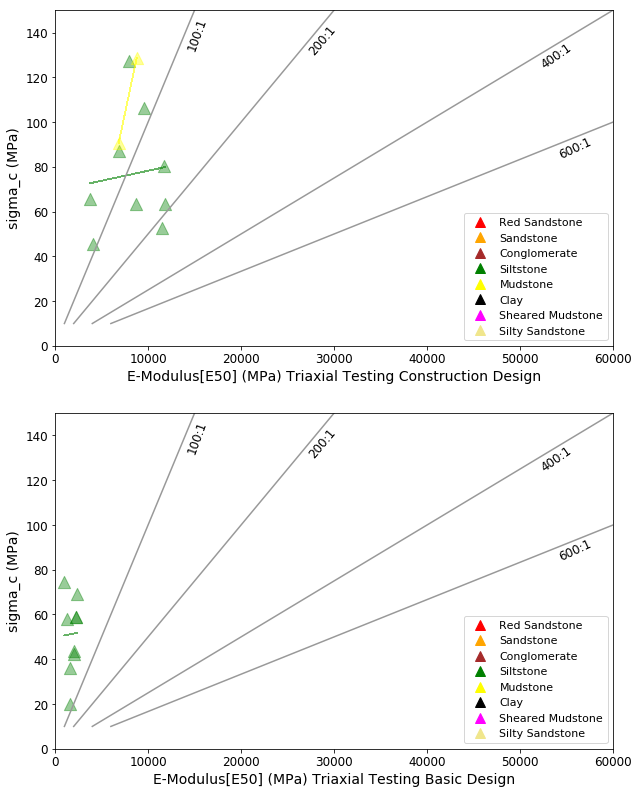

In [49]:
# scatterplot of E50 against sigma_c for all rock lithologies
# input: data_E_adj, data_sigma_c_adj containing ordered 'values' of 'parameter' E and sigma_c,
#        ordering using 'borehole_code' and sample_depth_top_m
# prcocedure needs to be robust, check that correct ordered pairs are always plotted                       #ToDo JK

# lithologies: defined above 
E={}
sigma_c={}

# select E, sgima_c data pairs and write to dictionary
# select for construction phase implies that E and sigma_c values are both in same phase, correct?        #ToDo JK
def selected_pairs(sample_description):
    E.clear()
    sigma_c.clear()
    for lithology in lithologies:
        E[lithology]=[]  #initialize dictionary
        sigma_c[lithology]=[]  #initialize dictionary
    for i in range(len(data_E_adj)):
        if (data_E_adj[i]['value']) != 'NaN':  #ignore NaN values    
            if (data_E_adj[i]['sample_description']) == sample_description:  #select for phase
                for lithology in lithologies:  # select for lithology
                    if (data_E_adj[i]['lithology']) == lithology:
                        if float(data_E_adj[i]['value']):  #this is only check for E, not sigma_c         #ToDo JK
                            E[lithology].append(float(data_E_adj[i]['value']))
                            sigma_c[lithology].append(float(data_sigma_c_adj[i]['value']))

def scatter_plot(E_, sigma_c_, lithology, sample_description):
    if E_.any():  # if E values are present for a selected lithology
        # scatterplot for values of selected lithology
        plt.scatter(E_,sigma_c_,
                    marker='^',s= 150.,facecolor=colors[lithology],alpha=0.4)
        #calculate linear regression
        line=(); s1=(); s3=(); intercept=0.; slope=0.; std_err=0.
        slope, intercept, r_value, p_value, std_err = stats.linregress(E_,sigma_c_)
        line = slope*E_+intercept
        plt.plot(E_,line, color=colors[lithology],alpha=0.6,linewidth=0.8,antialiased=False)
        print(sample_description+'  '+lithology+'  '+
              'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

def legend():    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="magenta")
    sym8 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="khaki")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym8),
               ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone",
                "Silty Sandstone"),
                 fontsize=11, numpoints=1,loc="lower right")

def trend():
# show a reference trend line
    plt.plot((1000,10000,20000,30000),(10,100,200,300),color='0.6')
    plt.annotate("100:1",xy=(14000,143),xytext=(14000,143),rotation=70,fontsize=12)
    plt.plot((2000,20000,40000,60000),(10,100,200,300),color='0.6')
    plt.annotate("200:1",xy=(27000,140),xytext=(27000,140),rotation=50,fontsize=12)
    plt.plot((4000,40000,60000),(10,100,150),color='0.6')
    plt.annotate("400:1",xy=(52000,132),xytext=(52000,132),rotation=35,fontsize=12)
    plt.plot((6000,60000),(10,100),color='0.6')
    plt.annotate("600:1",xy=(54000,90),xytext=(54000,90),rotation=25,fontsize=12)


plt.figure(figsize=(10, 21))

plt.subplot(311)
selected_pairs('Construction Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Construction Design')
    
plt.xlim((0,60000))
plt.ylim((0,150))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Triaxial Testing Construction Design',fontsize=14)
trend()
legend()
# check plot values
#print E
#print sigma_c

plt.subplot(312)
selected_pairs('Basic Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Basic Design')

plt.xlim((0,60000))
plt.ylim((0,150))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Triaxial Testing Basic Design',fontsize=14)
trend()
legend()
# check plot values
#print E
#print sigma_c

plt.show()